In [1]:
import logging
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from typing import Optional, List, Collection

from causalpy import Assignment
from causalpy.causal_prediction.interventional import (
    AgnosticPredictor,
    MultiAgnosticPredictor,
)
from causalpy.neural_networks import CINN
from examples.study_cases import study_scm, generate_data_from_scm
import numpy as np
import torch

from time import gmtime, strftime
import os

from tqdm import tqdm
import matplotlib.pyplot as plt



/home/michael/anaconda3/envs/causalpy/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def run_scenario(
    coeffs, sample_size, nr_runs, epochs, scenario, step, **kwargs
):
    seed = 0
    np.random.seed(seed)
    # print(coeffs)
    scm = study_scm(seed=seed, coeffs_by_var=coeffs)
    sscm = study_scm(seed=seed)
    standard_sample = sscm.sample(sample_size)

    (
        data,
        environments,
        scm,
        possible_parents,
        target_parents,
    ) = generate_data_from_scm(scm, target_var="Y", sample_size=sample_size, seed=seed)

    plt.hist(
        standard_sample["Y"],
        color="green",
        label="Standard Linear",
        density=True,
        bins=100,
        alpha=0.5,
    )
    plt.hist(
        data["Y"],
        color="red",
        label=f"NONLINEAR {coeffs}",
        density=True,
        bins=100,
        alpha=0.5,
    )

    plt.legend()
    plt.show()

In [8]:
def return_coeffs_by_var(coeffs, scenario):
    if scenario == "parents":
        coeffs_by_var = {"X_1": [coeffs], "X_2": [coeffs]}
    elif scenario == "children":
        coeffs_by_var = {"X_3": [coeffs], "X_6": [coeffs, coeffs]}
    elif scenario == "target":
        coeffs_by_var = {"Y": [coeffs, coeffs]}
    elif scenario == "all":
        coeffs_by_var = {
            "X_1": [coeffs],
            "X_2": [coeffs],
            "X_3": [coeffs],
            "X_4": [coeffs],
            "X_6": [coeffs, coeffs],
            "Y": [coeffs, coeffs],
        }
    return coeffs_by_var


Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.1 X_0**2 + -0.01 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.1 X_0**2 + -0.01 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

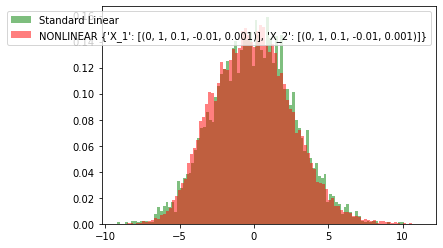

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.2 X_0**2 + -0.02 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.2 X_0**2 + -0.02 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

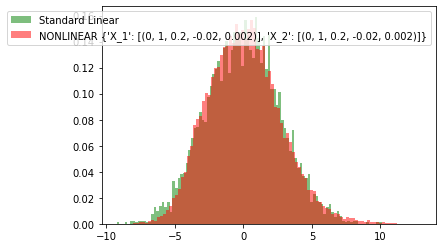

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.3 X_0**2 + -0.03 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.3 X_0**2 + -0.03 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

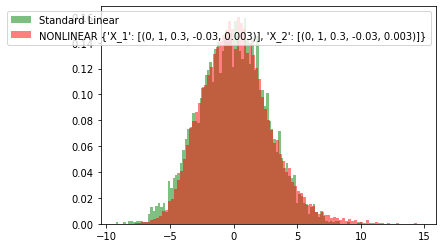

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.4 X_0**2 + -0.04 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.4 X_0**2 + -0.04 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

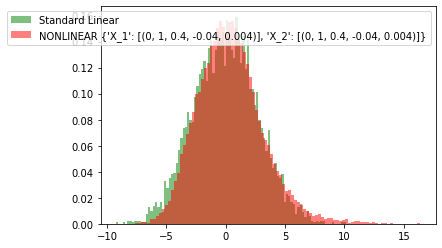

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.5 X_0**2 + -0.05 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.5 X_0**2 + -0.05 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

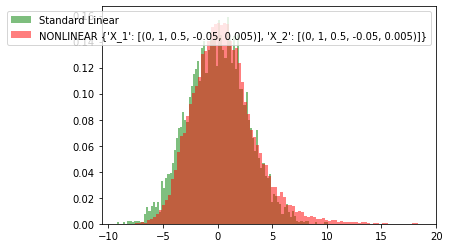

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.6 X_0**2 + -0.06 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.6 X_0**2 + -0.06 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

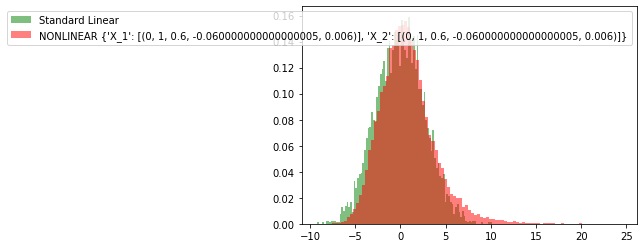

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.7 X_0**2 + -0.07 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.7 X_0**2 + -0.07 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

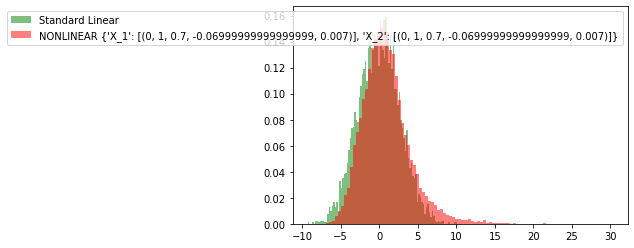

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.8 X_0**2 + -0.08 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.8 X_0**2 + -0.08 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

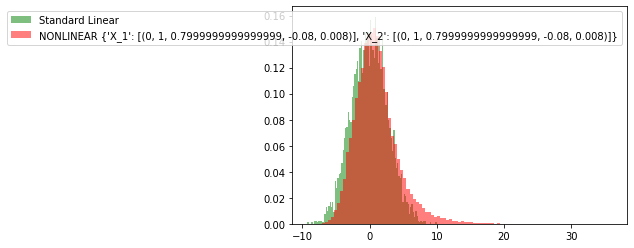

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.9 X_0**2 + -0.09 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.9 X_0**2 + -0.09 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

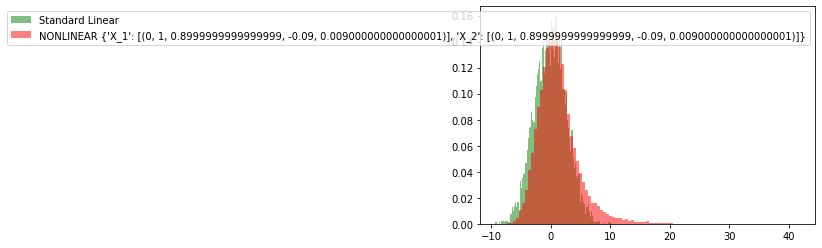

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.0 X_0**2 + -0.1 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.0 X_0**2 + -0.1 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

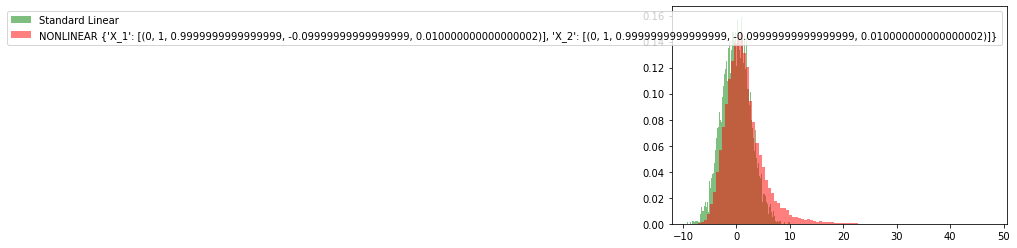

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.1 X_0**2 + -0.11 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.1 X_0**2 + -0.11 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

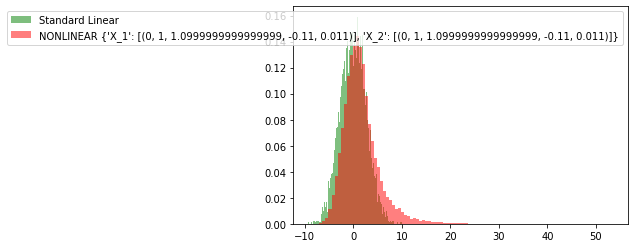

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.2 X_0**2 + -0.12 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.2 X_0**2 + -0.12 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

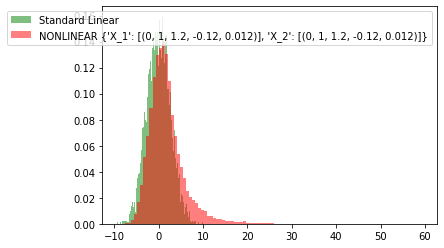

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.3 X_0**2 + -0.13 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.3 X_0**2 + -0.13 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

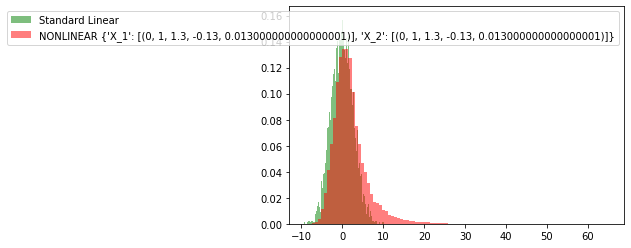

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.4 X_0**2 + -0.14 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.4 X_0**2 + -0.14 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

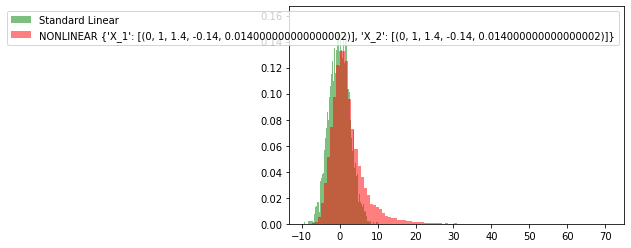

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.5 X_0**2 + -0.15 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.5 X_0**2 + -0.15 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

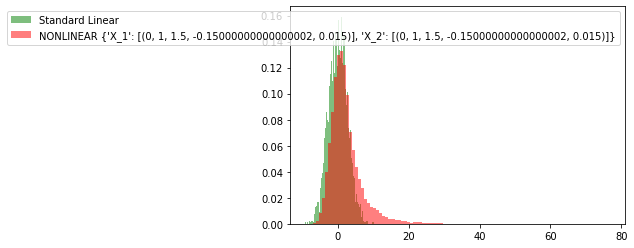

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.6 X_0**2 + -0.16 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.6 X_0**2 + -0.16 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

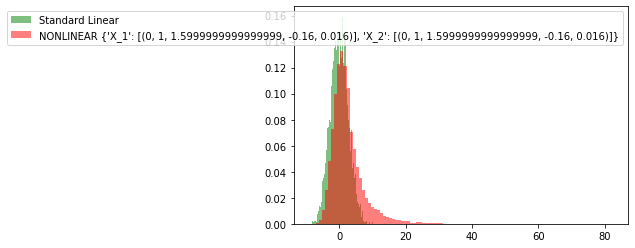

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.7 X_0**2 + -0.17 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.7 X_0**2 + -0.17 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

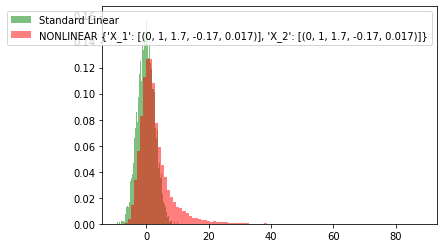

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.8 X_0**2 + -0.18 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.8 X_0**2 + -0.18 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

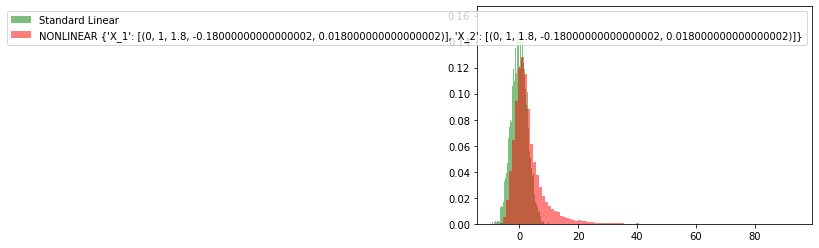

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.9 X_0**2 + -0.19 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.9 X_0**2 + -0.19 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

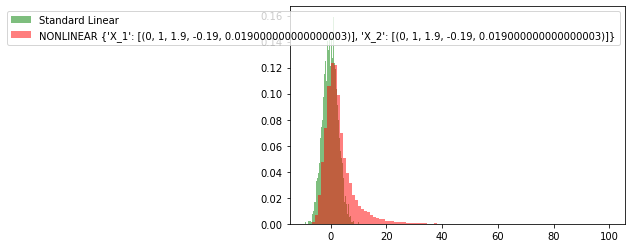

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.0 X_0**2 + -0.2 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.0 X_0**2 + -0.2 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

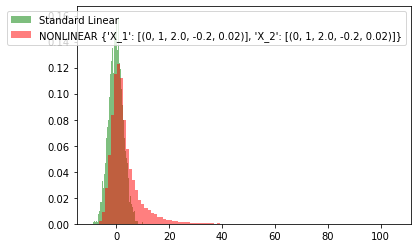

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.1 X_0**2 + -0.21 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.1 X_0**2 + -0.21 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

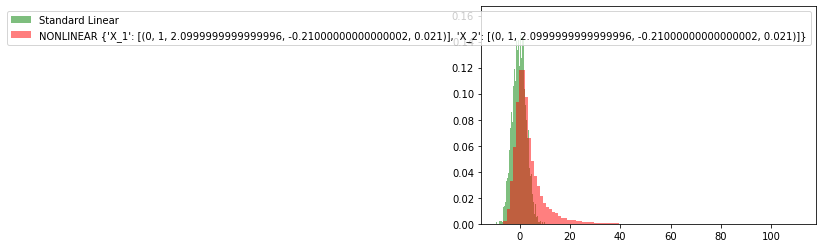

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.2 X_0**2 + -0.22 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.2 X_0**2 + -0.22 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

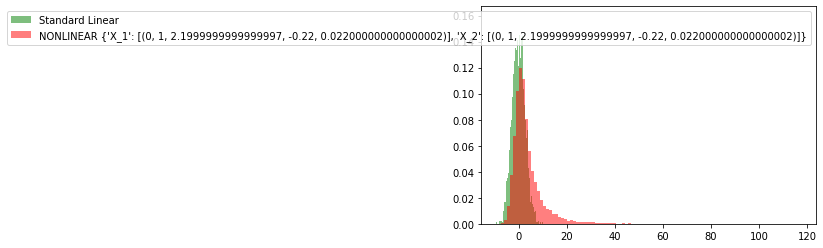

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.3 X_0**2 + -0.23 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.3 X_0**2 + -0.23 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

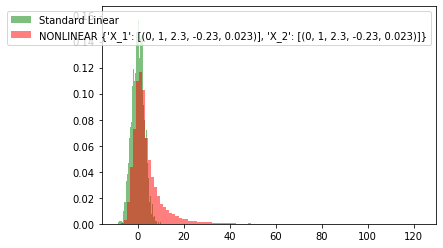

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.4 X_0**2 + -0.24 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.4 X_0**2 + -0.24 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

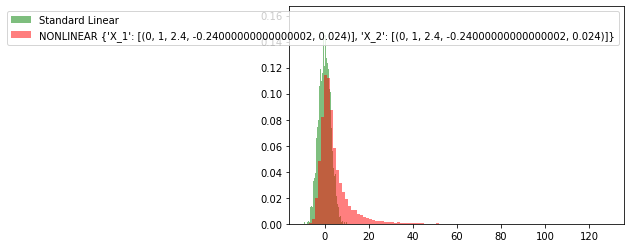

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.5 X_0**2 + -0.25 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.5 X_0**2 + -0.25 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

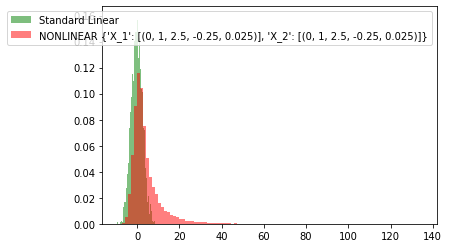

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.6 X_0**2 + -0.26 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.6 X_0**2 + -0.26 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

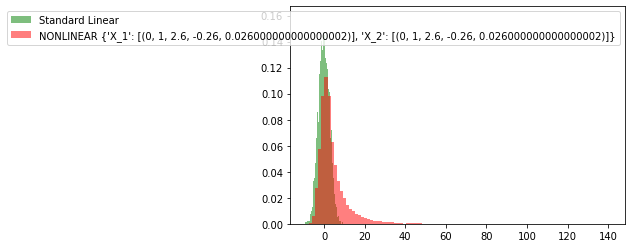

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.7 X_0**2 + -0.27 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.7 X_0**2 + -0.27 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

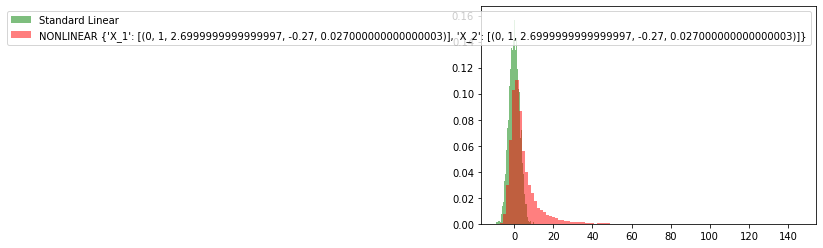

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.8 X_0**2 + -0.28 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.8 X_0**2 + -0.28 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

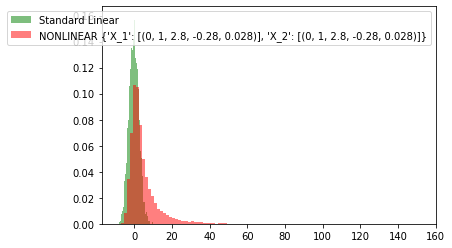

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.9 X_0**2 + -0.29 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.9 X_0**2 + -0.29 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

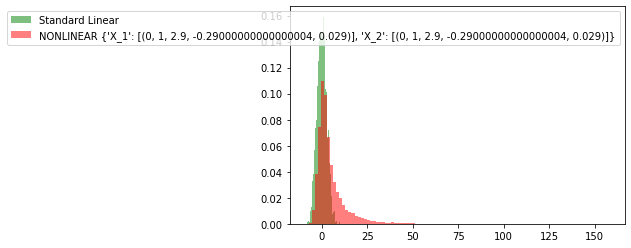

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.0 X_0**2 + -0.3 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.0 X_0**2 + -0.3 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

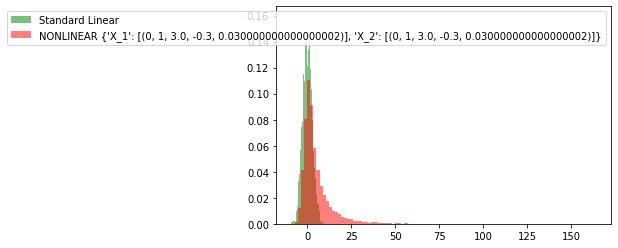

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.1 X_0**2 + -0.31 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.1 X_0**2 + -0.31 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

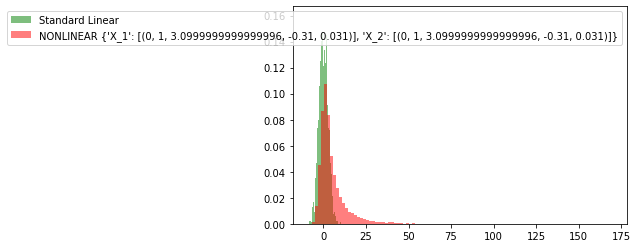

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.2 X_0**2 + -0.32 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.2 X_0**2 + -0.32 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

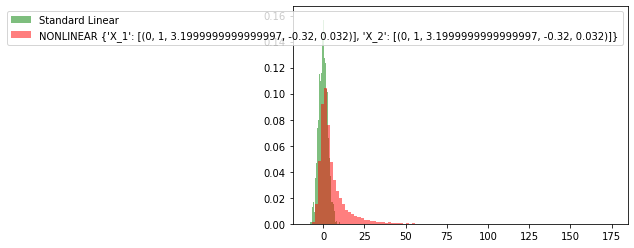

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.3 X_0**2 + -0.33 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.3 X_0**2 + -0.33 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

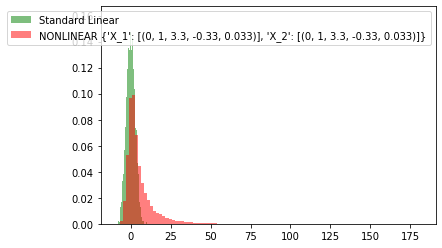

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.4 X_0**2 + -0.34 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.4 X_0**2 + -0.34 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

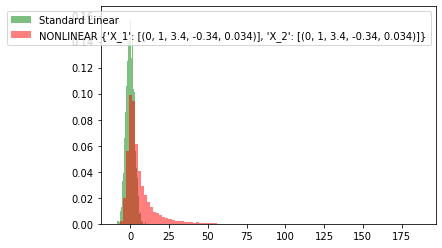

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.5 X_0**2 + -0.35 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.5 X_0**2 + -0.35 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

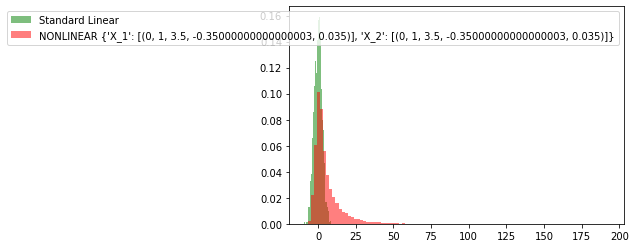

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.6 X_0**2 + -0.36 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.6 X_0**2 + -0.36 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

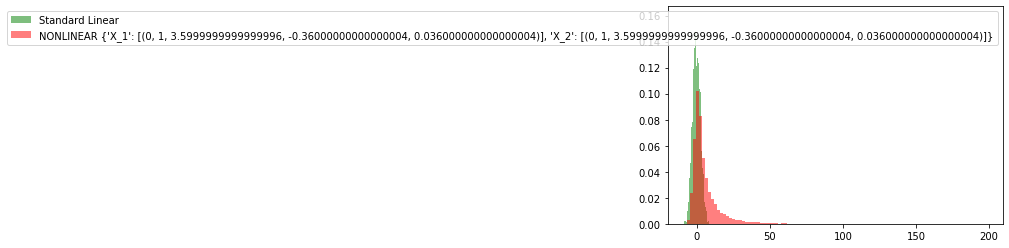

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.7 X_0**2 + -0.37 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.7 X_0**2 + -0.37 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

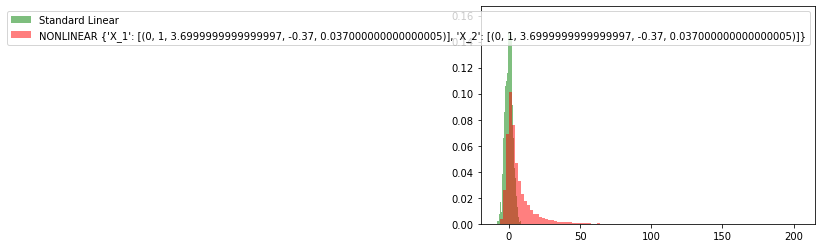

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.8 X_0**2 + -0.38 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.8 X_0**2 + -0.38 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

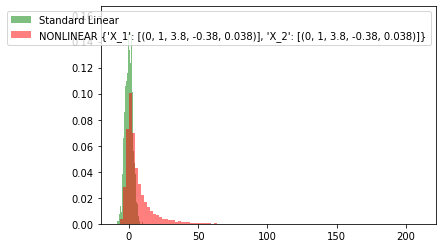

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.9 X_0**2 + -0.39 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.9 X_0**2 + -0.39 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

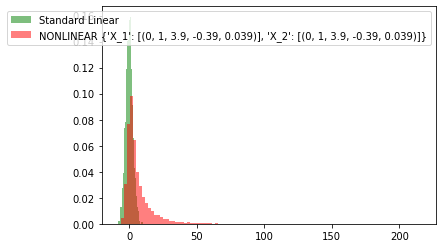

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 4.0 X_0**2 + -0.4 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 4.0 X_0**2 + -0.4 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

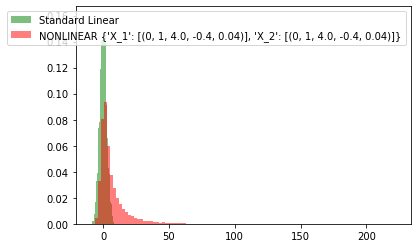

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.1 Y**2 + -0.01 Y**3 + 0.0 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.1 Y**2 +

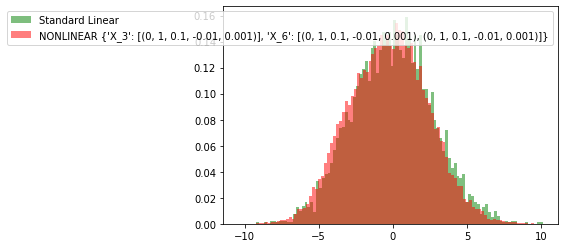

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.2 Y**2 + -0.02 Y**3 + 0.0 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.2 Y**2 +

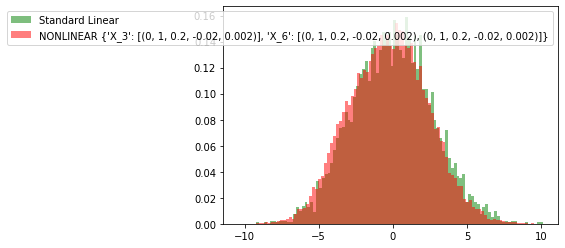

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.3 Y**2 + -0.03 Y**3 + 0.0 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.3 Y**2 +

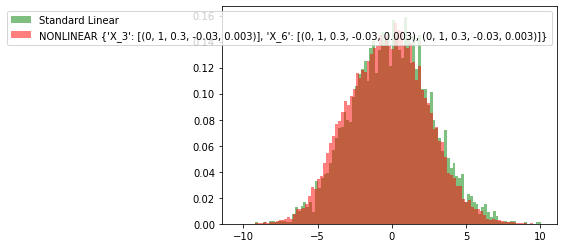

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.4 Y**2 + -0.04 Y**3 + 0.0 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.4 Y**2 +

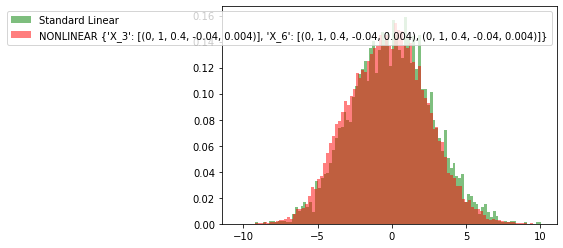

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.5 Y**2 + -0.05 Y**3 + 0.0 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.5 Y**2 +

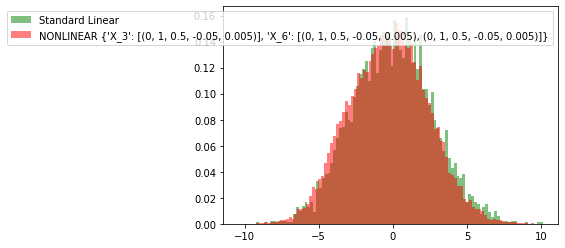

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.6 Y**2 + -0.06 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.6 Y**2 

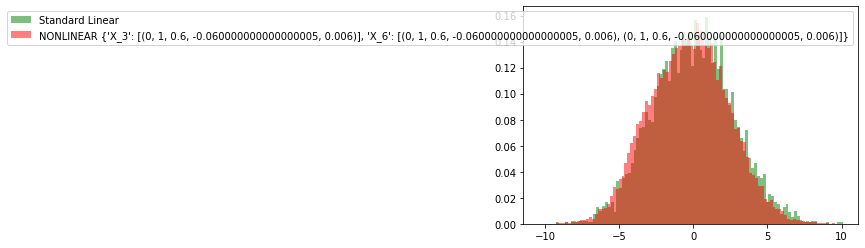

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.7 Y**2 + -0.07 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.7 Y**2 

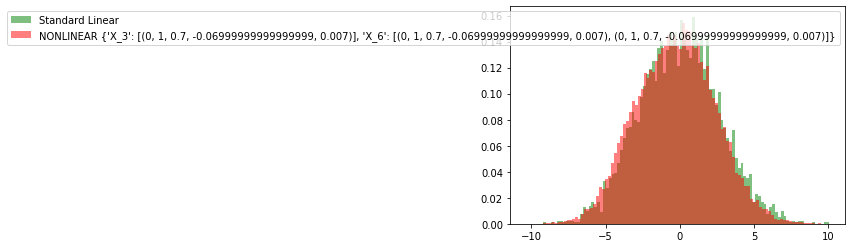

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.8 Y**2 + -0.08 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.8 Y**2 

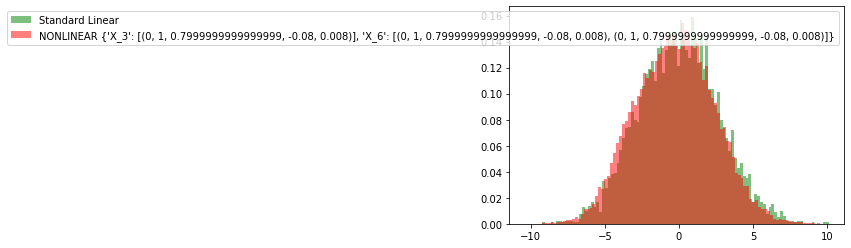

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.9 Y**2 + -0.09 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 0.9 Y**2 

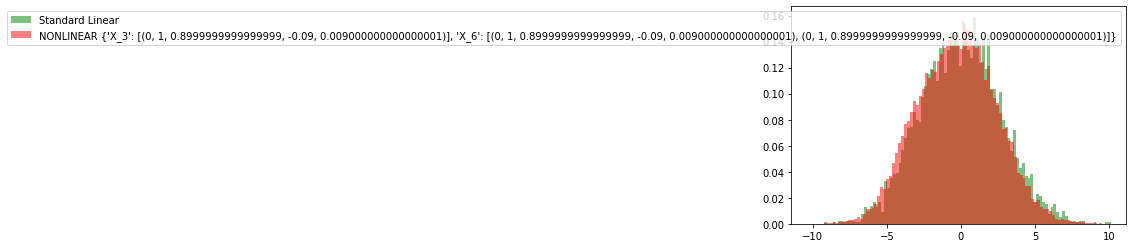

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.0 Y**2 + -0.1 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.0 Y**2 +

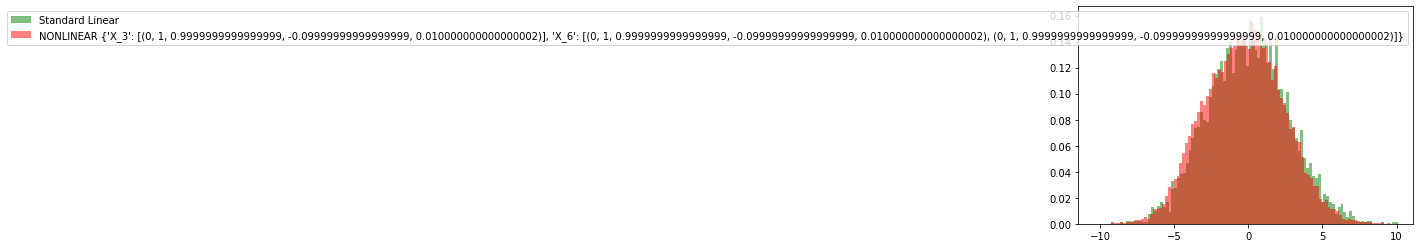

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.1 Y**2 + -0.11 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.1 Y**2 

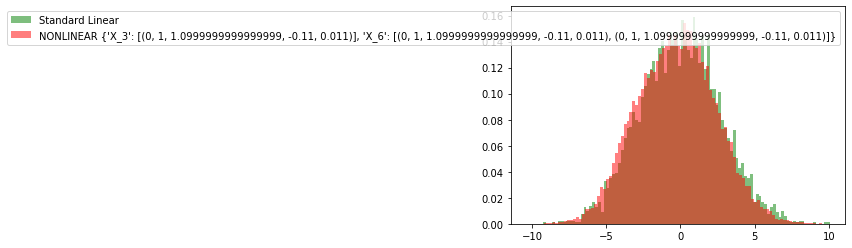

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.2 Y**2 + -0.12 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.2 Y**2 

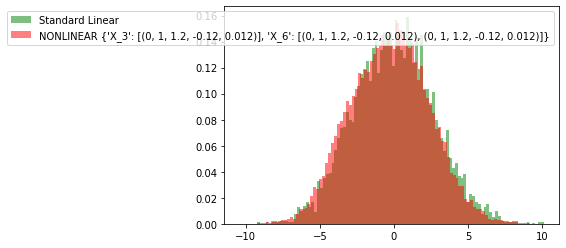

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.3 Y**2 + -0.13 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.3 Y**2 

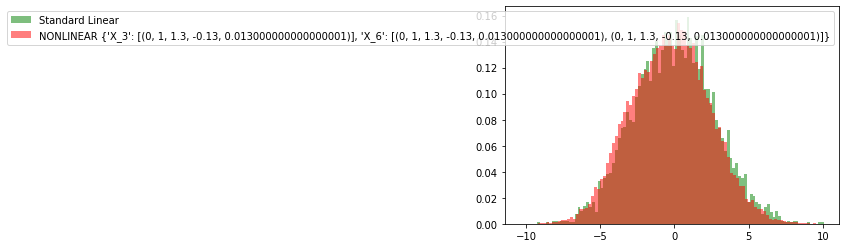

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.4 Y**2 + -0.14 Y**3 + 0.01 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.4 Y**2 

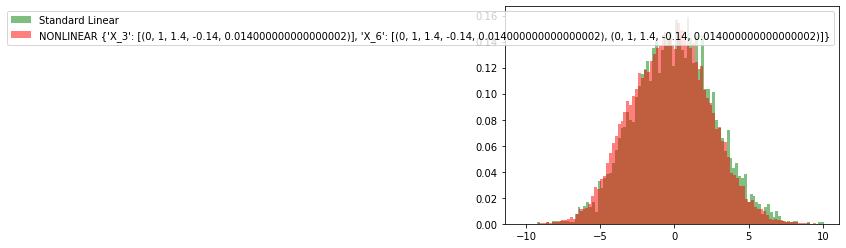

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.5 Y**2 + -0.15 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.5 Y**2 

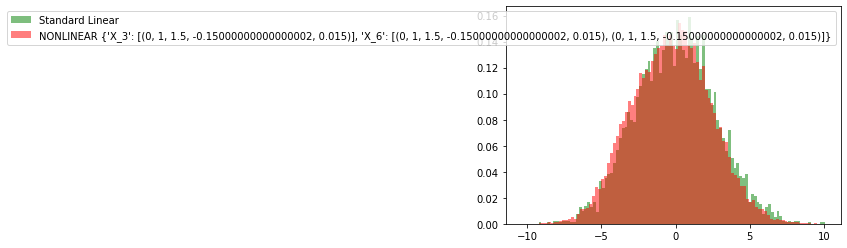

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.6 Y**2 + -0.16 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.6 Y**2 

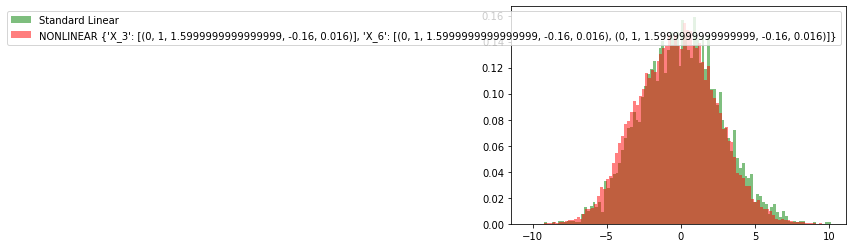

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.7 Y**2 + -0.17 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.7 Y**2 

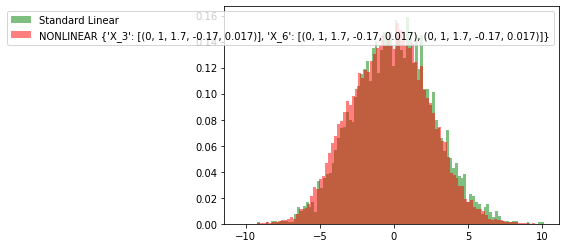

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.8 Y**2 + -0.18 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.8 Y**2 

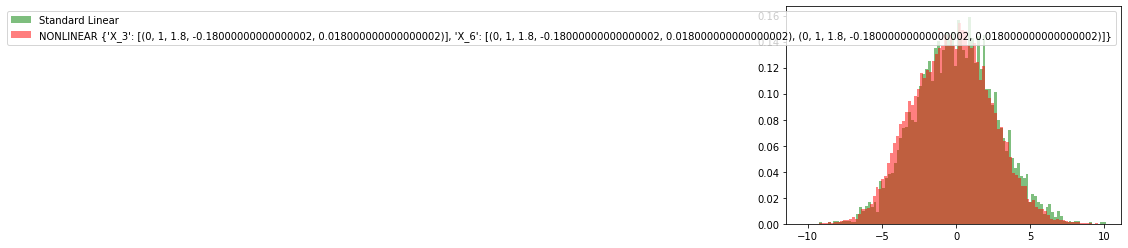

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.9 Y**2 + -0.19 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 1.9 Y**2 

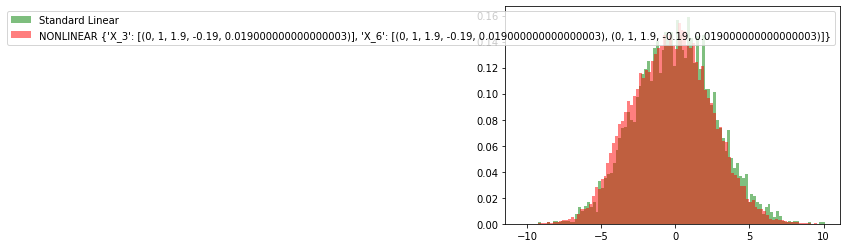

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.0 Y**2 + -0.2 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.0 Y**2 +

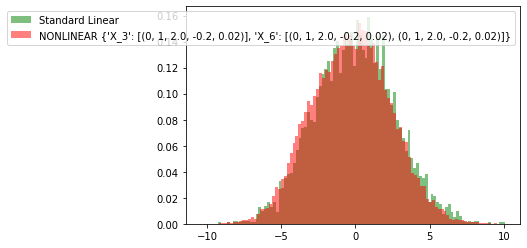

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.1 Y**2 + -0.21 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.1 Y**2 

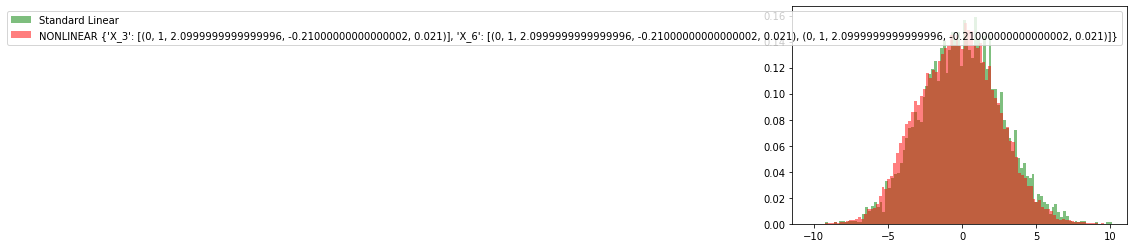

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.2 Y**2 + -0.22 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.2 Y**2 

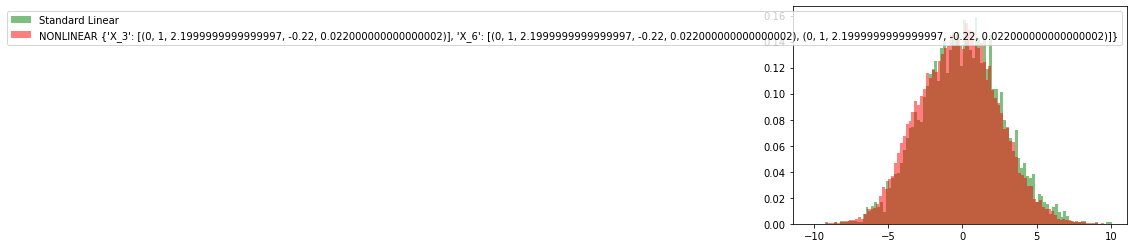

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.3 Y**2 + -0.23 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.3 Y**2 

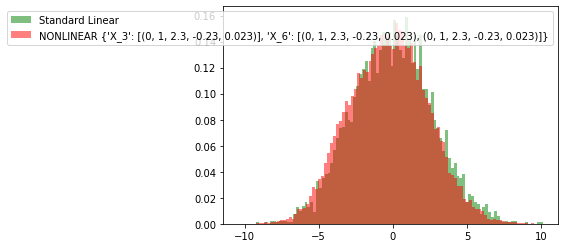

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.4 Y**2 + -0.24 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.4 Y**2 

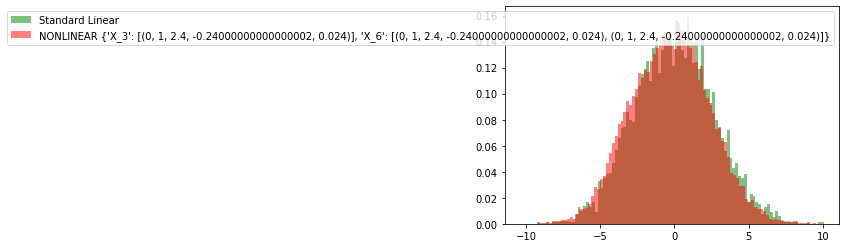

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.5 Y**2 + -0.25 Y**3 + 0.02 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.5 Y**2 

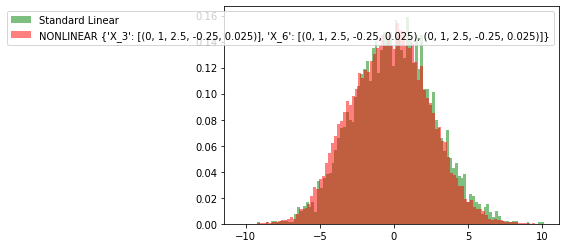

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.6 Y**2 + -0.26 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.6 Y**2 

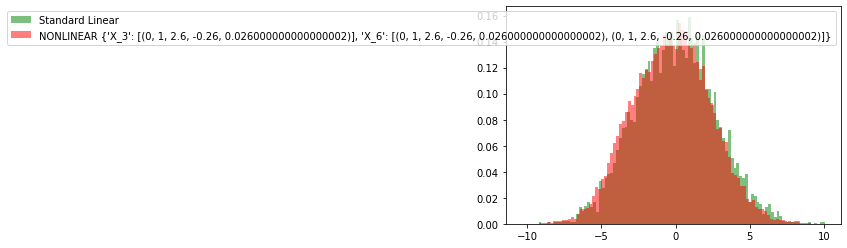

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.7 Y**2 + -0.27 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.7 Y**2 

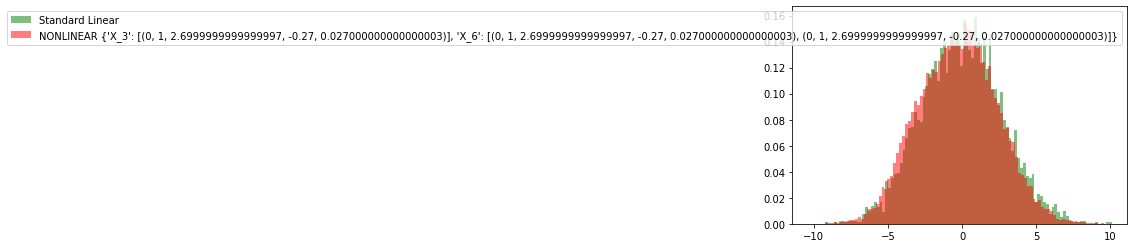

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.8 Y**2 + -0.28 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.8 Y**2 

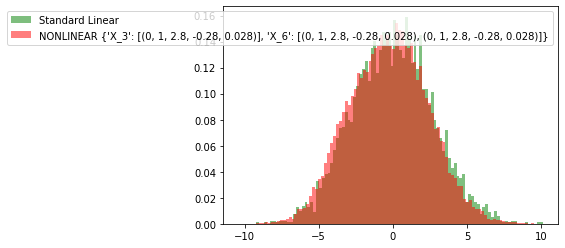

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.9 Y**2 + -0.29 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 2.9 Y**2 

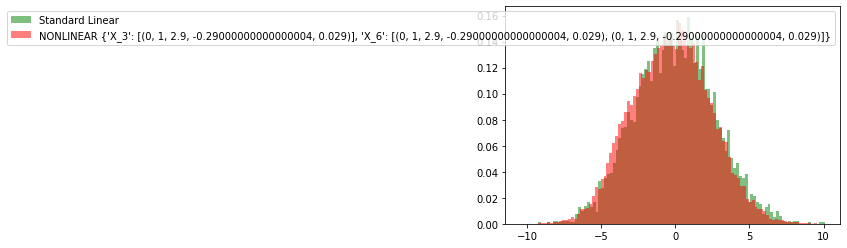

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.0 Y**2 + -0.3 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.0 Y**2 +

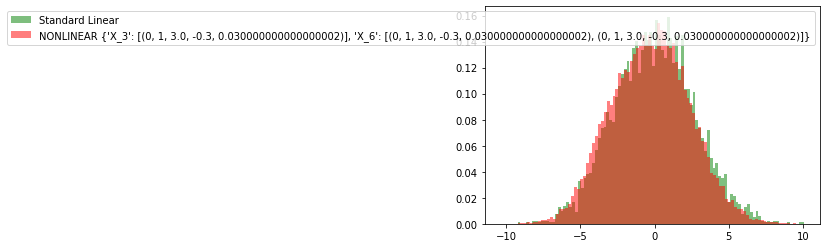

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.1 Y**2 + -0.31 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.1 Y**2 

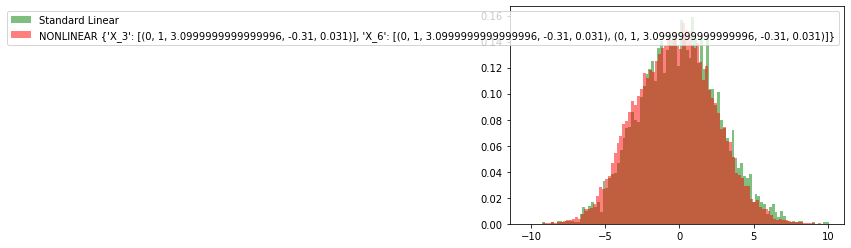

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.2 Y**2 + -0.32 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.2 Y**2 

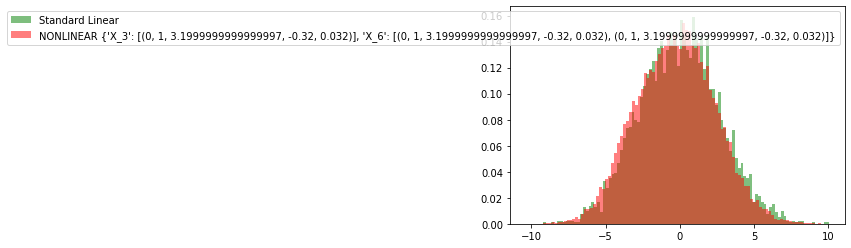

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.3 Y**2 + -0.33 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.3 Y**2 

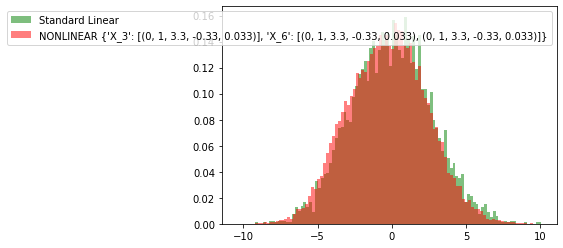

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.4 Y**2 + -0.34 Y**3 + 0.03 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.4 Y**2 

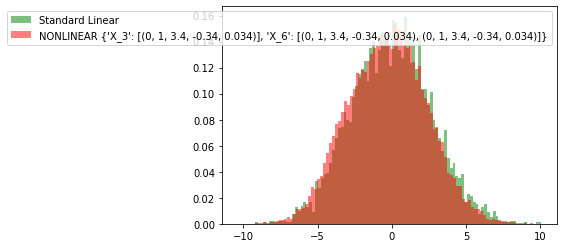

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.5 Y**2 + -0.35 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.5 Y**2 

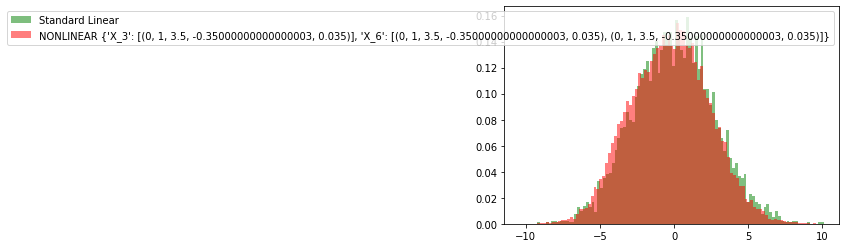

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.6 Y**2 + -0.36 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.6 Y**2 

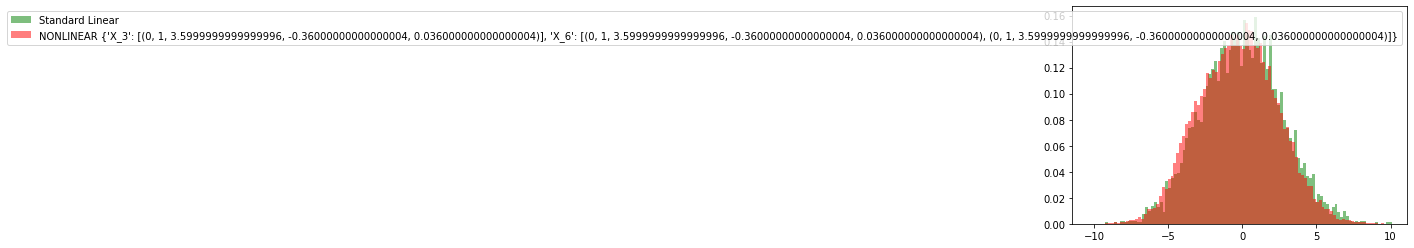

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.7 Y**2 + -0.37 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.7 Y**2 

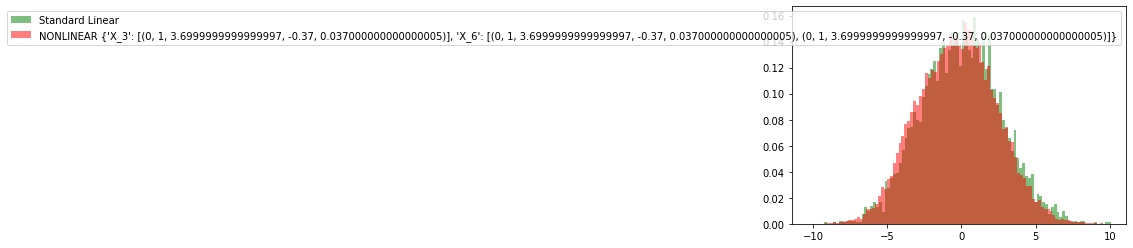

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.8 Y**2 + -0.38 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.8 Y**2 

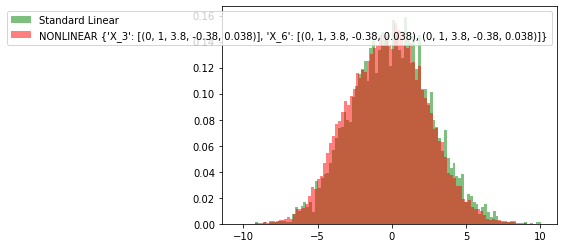

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.9 Y**2 + -0.39 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 3.9 Y**2 

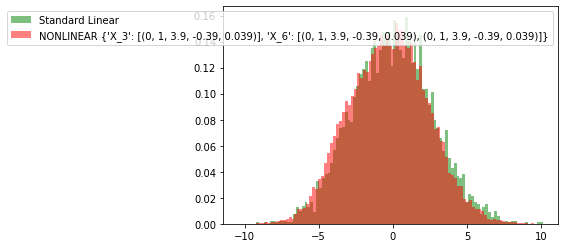

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_2	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 4.0 Y**2 + -0.4 Y**3 + 0.04 Y**4	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_6 := f(N, Y, X_5) = 1.0 N + 1.0 Y + 4.0 Y**2 +

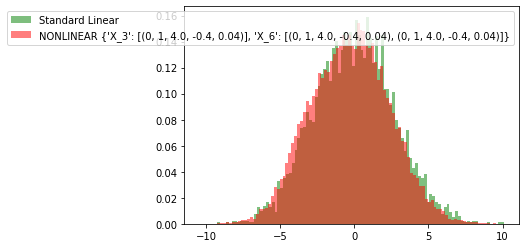

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.1 X_1**2 + -0.01 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.1 X_2**2 + -0.01 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

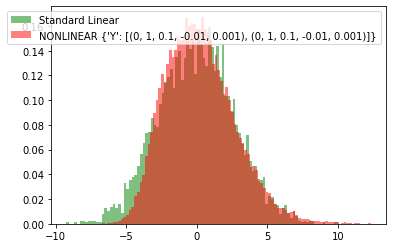

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.2 X_1**2 + -0.02 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.2 X_2**2 + -0.02 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

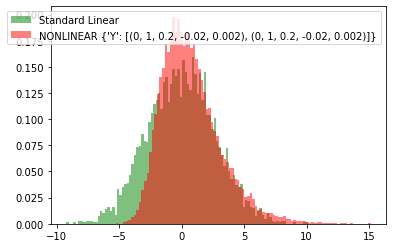

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.3 X_1**2 + -0.03 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.3 X_2**2 + -0.03 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

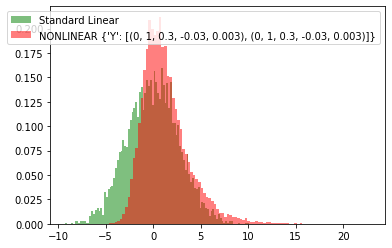

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.4 X_1**2 + -0.04 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.4 X_2**2 + -0.04 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

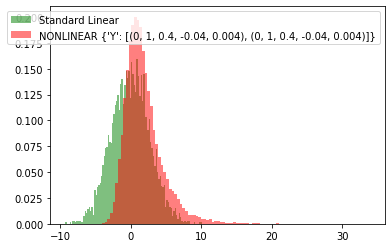

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.5 X_1**2 + -0.05 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.5 X_2**2 + -0.05 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

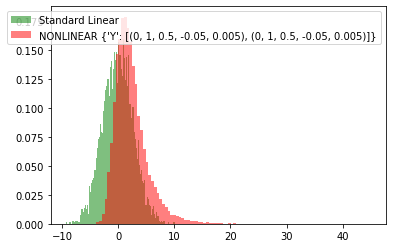

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.6 X_1**2 + -0.06 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.6 X_2**2 + -0.06 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

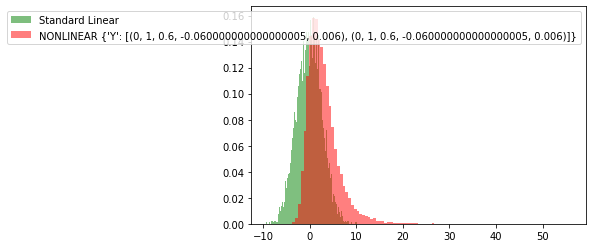

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.7 X_1**2 + -0.07 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.7 X_2**2 + -0.07 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

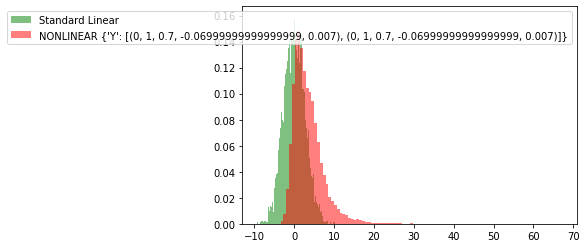

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.8 X_1**2 + -0.08 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.8 X_2**2 + -0.08 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

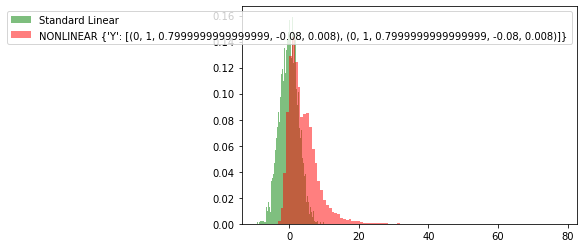

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.9 X_1**2 + -0.09 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.9 X_2**2 + -0.09 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

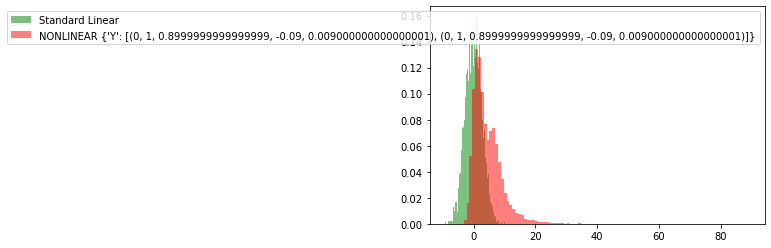

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_1**2 + -0.1 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.0 X_2**2 + -0.1 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

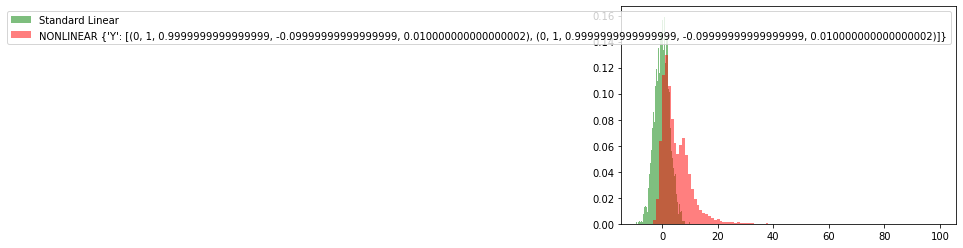

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.1 X_1**2 + -0.11 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.1 X_2**2 + -0.11 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

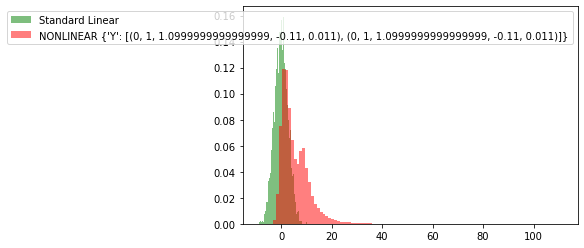

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.2 X_1**2 + -0.12 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.2 X_2**2 + -0.12 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

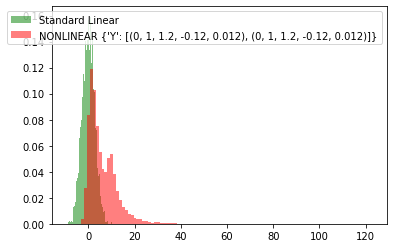

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.3 X_1**2 + -0.13 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.3 X_2**2 + -0.13 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

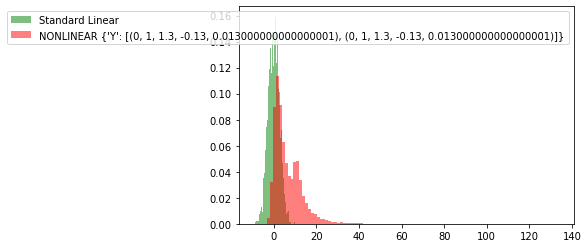

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.4 X_1**2 + -0.14 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.4 X_2**2 + -0.14 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

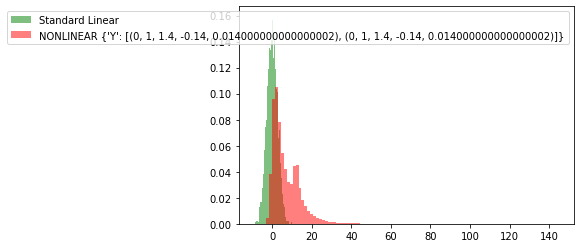

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.5 X_1**2 + -0.15 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.5 X_2**2 + -0.15 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

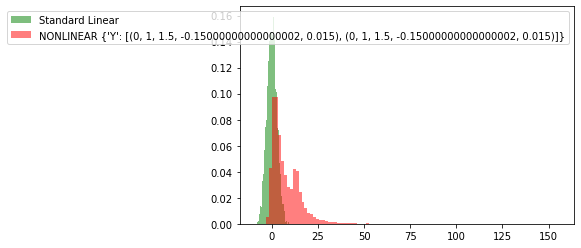

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.6 X_1**2 + -0.16 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.6 X_2**2 + -0.16 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

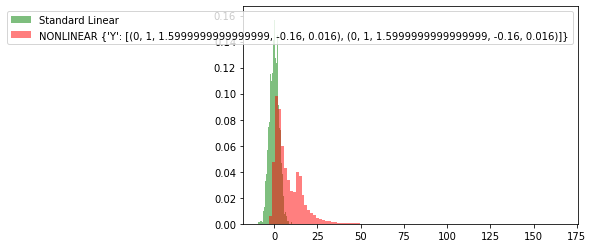

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.7 X_1**2 + -0.17 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.7 X_2**2 + -0.17 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

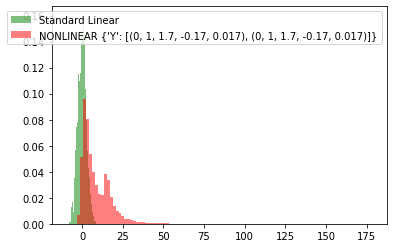

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.8 X_1**2 + -0.18 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.8 X_2**2 + -0.18 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

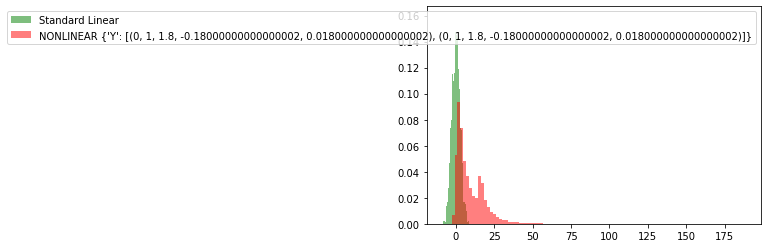

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.9 X_1**2 + -0.19 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.9 X_2**2 + -0.19 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

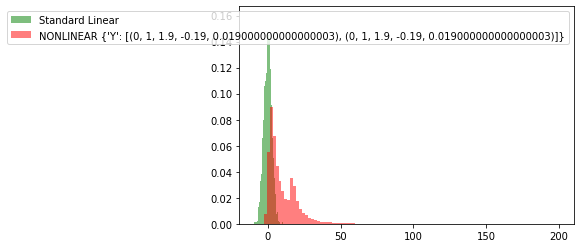

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.0 X_1**2 + -0.2 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.0 X_2**2 + -0.2 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

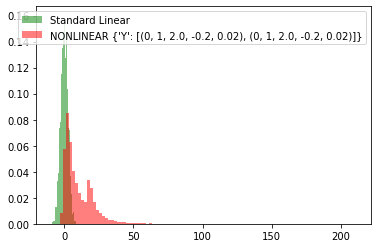

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.1 X_1**2 + -0.21 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.1 X_2**2 + -0.21 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

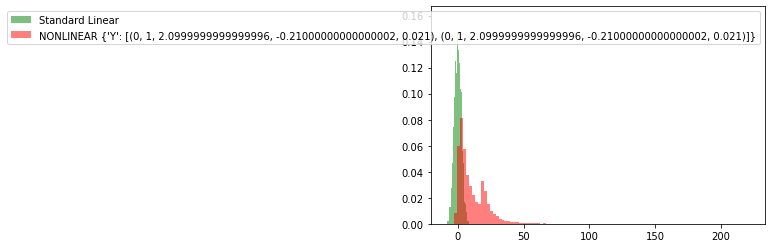

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.2 X_1**2 + -0.22 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.2 X_2**2 + -0.22 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

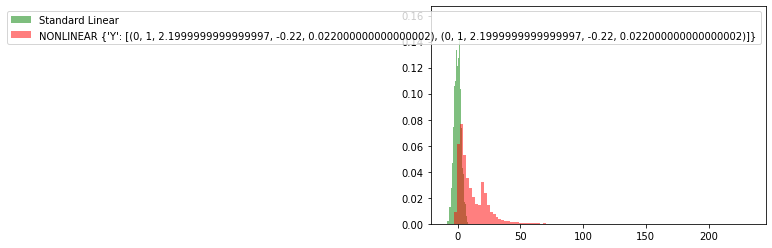

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.3 X_1**2 + -0.23 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.3 X_2**2 + -0.23 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

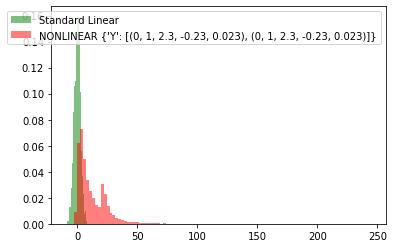

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.4 X_1**2 + -0.24 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.4 X_2**2 + -0.24 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

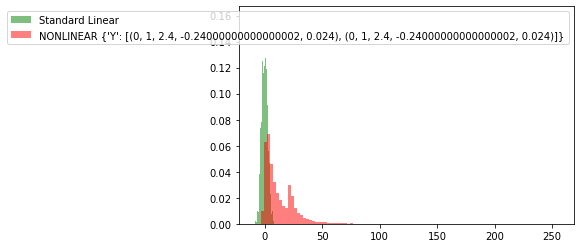

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.5 X_1**2 + -0.25 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.5 X_2**2 + -0.25 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

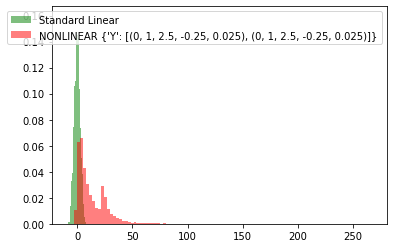

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.6 X_1**2 + -0.26 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.6 X_2**2 + -0.26 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

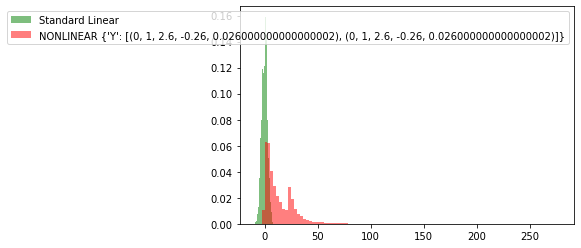

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.7 X_1**2 + -0.27 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.7 X_2**2 + -0.27 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

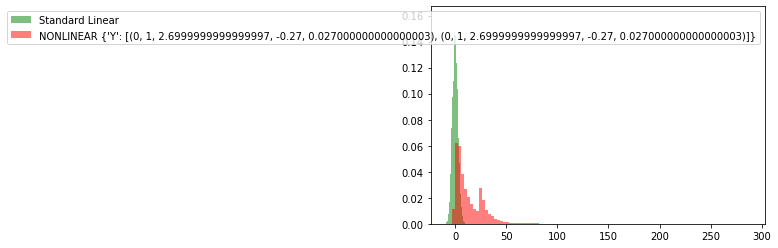

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.8 X_1**2 + -0.28 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.8 X_2**2 + -0.28 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

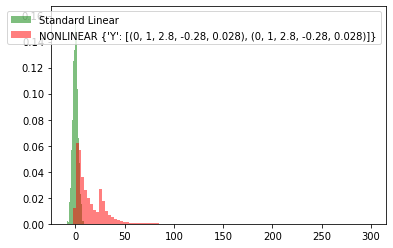

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.9 X_1**2 + -0.29 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.9 X_2**2 + -0.29 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

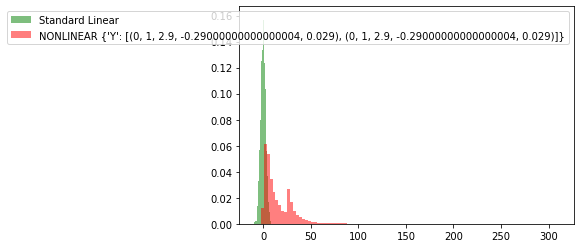

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.0 X_1**2 + -0.3 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.0 X_2**2 + -0.3 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

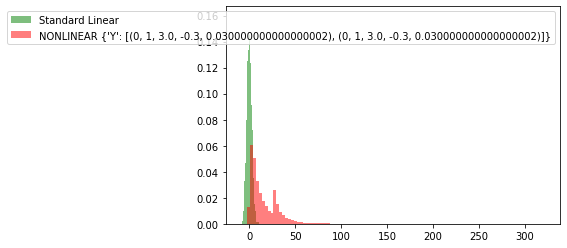

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.1 X_1**2 + -0.31 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.1 X_2**2 + -0.31 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

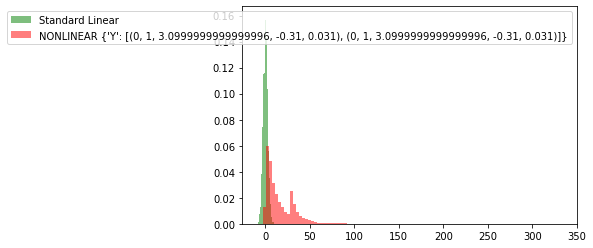

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.2 X_1**2 + -0.32 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.2 X_2**2 + -0.32 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

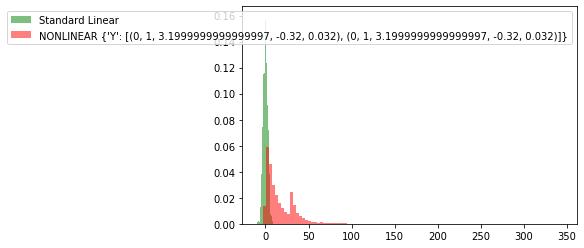

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.3 X_1**2 + -0.33 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.3 X_2**2 + -0.33 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

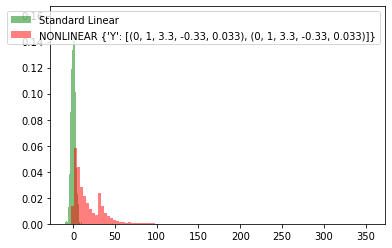

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.4 X_1**2 + -0.34 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.4 X_2**2 + -0.34 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

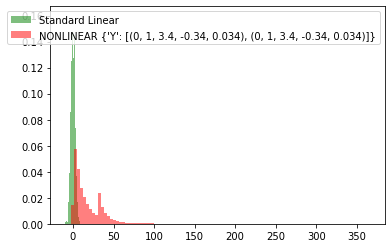

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.5 X_1**2 + -0.35 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.5 X_2**2 + -0.35 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

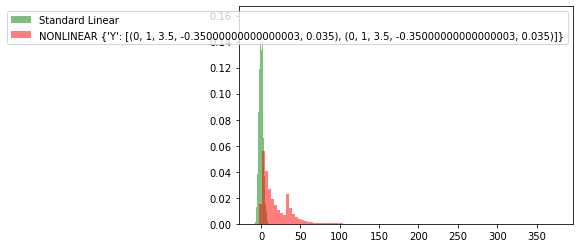

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.6 X_1**2 + -0.36 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.6 X_2**2 + -0.36 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

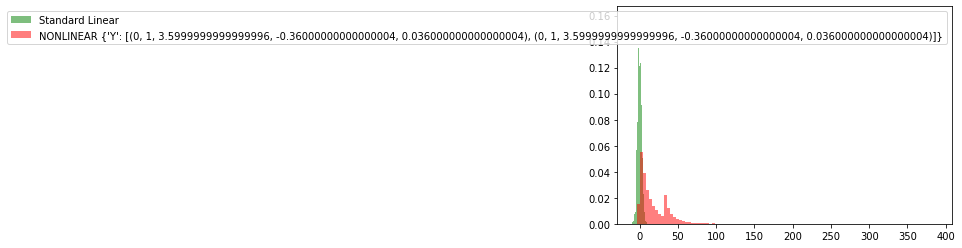

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.7 X_1**2 + -0.37 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.7 X_2**2 + -0.37 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

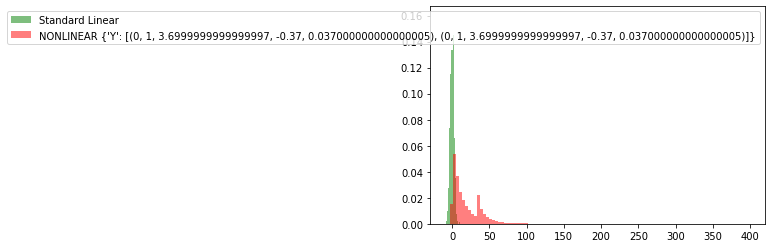

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.8 X_1**2 + -0.38 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.8 X_2**2 + -0.38 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

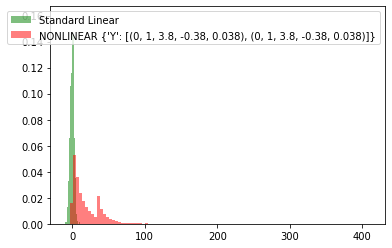

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.9 X_1**2 + -0.39 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.9 X_2**2 + -0.39 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]

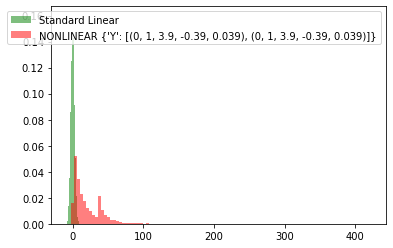

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 4.0 X_1**2 + -0.4 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 4.0 X_2**2 + -0.4 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y	 [ N := Standard Normal ]
X_4 := f(N, X_3) = 1.0 N + 1.0 X_3	 [ N := Standard Normal ]
X_5 := f(N) = 1.0 N	 [ N := Standard Normal ]
X

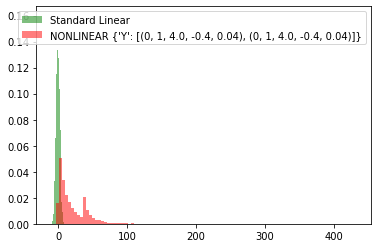

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.1 X_0**2 + -0.01 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.1 X_0**2 + -0.01 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.1 X_1**2 + -0.01 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.1 X_2**2 + -0.01 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.1 Y**2 + -0.01 Y**3 + 0.0 Y**4	 [ N := Standard 

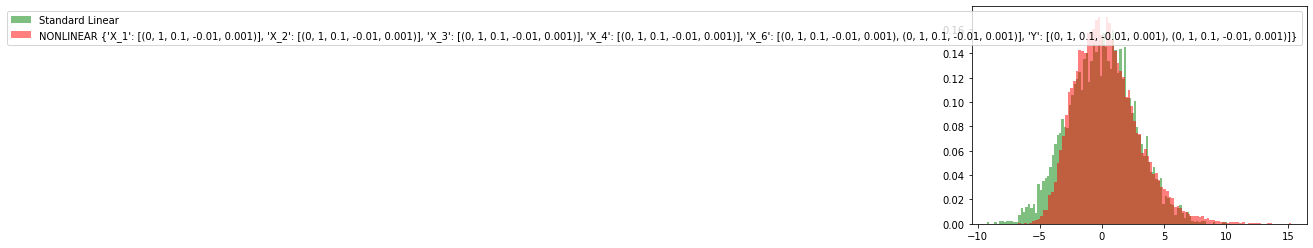

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.2 X_0**2 + -0.02 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.2 X_0**2 + -0.02 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.2 X_1**2 + -0.02 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.2 X_2**2 + -0.02 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.2 Y**2 + -0.02 Y**3 + 0.0 Y**4	 [ N := Standard 

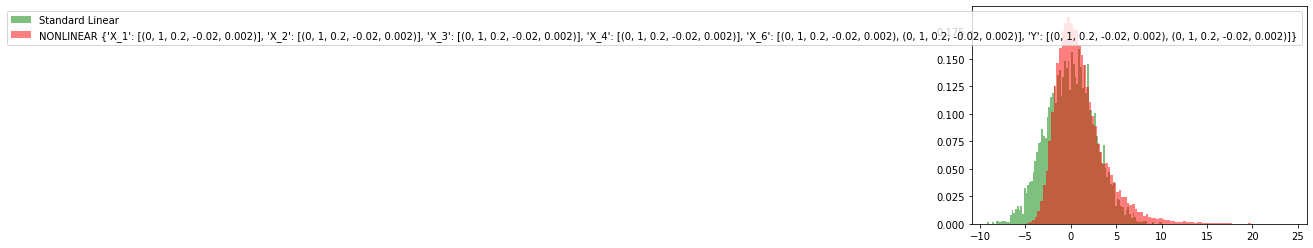

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.3 X_0**2 + -0.03 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.3 X_0**2 + -0.03 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.3 X_1**2 + -0.03 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.3 X_2**2 + -0.03 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.3 Y**2 + -0.03 Y**3 + 0.0 Y**4	 [ N := Standard 

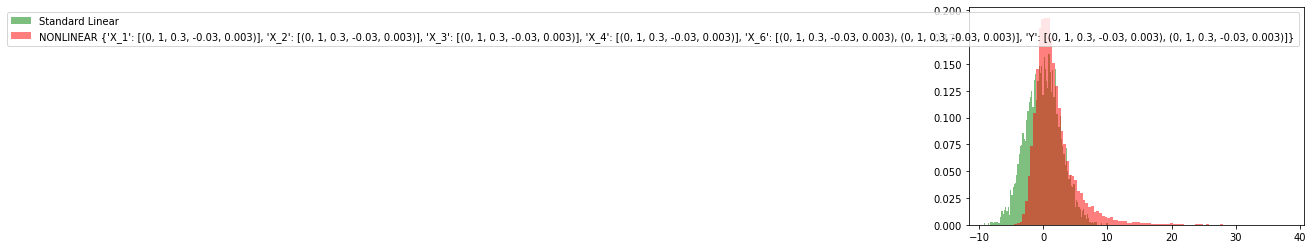

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.4 X_0**2 + -0.04 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.4 X_0**2 + -0.04 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.4 X_1**2 + -0.04 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.4 X_2**2 + -0.04 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.4 Y**2 + -0.04 Y**3 + 0.0 Y**4	 [ N := Standard 

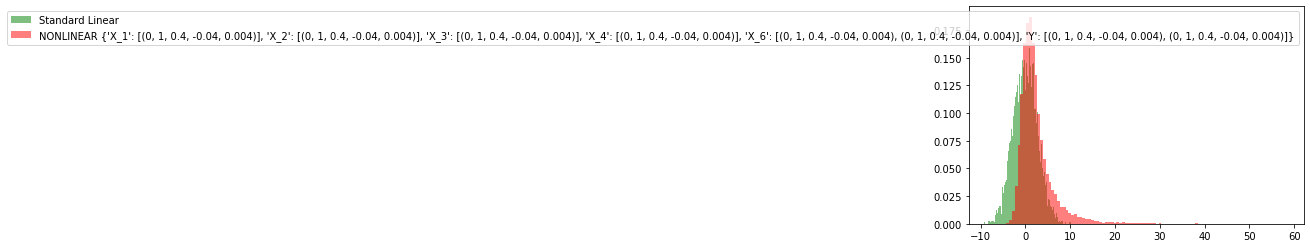

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.5 X_0**2 + -0.05 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.5 X_0**2 + -0.05 X_0**3 + 0.0 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.5 X_1**2 + -0.05 X_1**3 + 0.0 X_1**4 + 1.0 X_2 + 0.5 X_2**2 + -0.05 X_2**3 + 0.0 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.5 Y**2 + -0.05 Y**3 + 0.0 Y**4	 [ N := Standard 

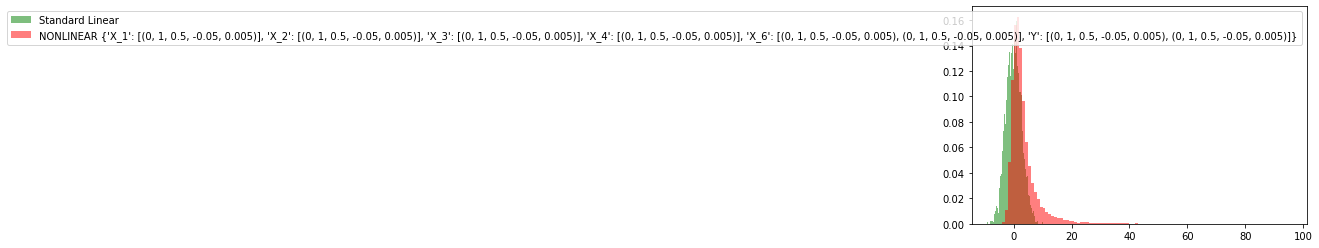

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.6 X_0**2 + -0.06 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.6 X_0**2 + -0.06 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.6 X_1**2 + -0.06 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.6 X_2**2 + -0.06 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.6 Y**2 + -0.06 Y**3 + 0.01 Y**4	 [ N := Stan

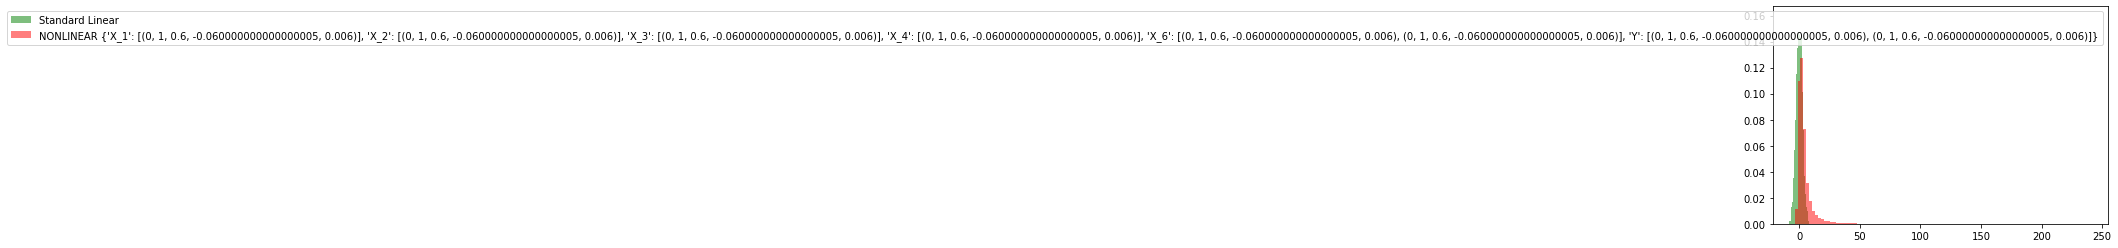

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.7 X_0**2 + -0.07 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.7 X_0**2 + -0.07 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.7 X_1**2 + -0.07 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.7 X_2**2 + -0.07 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.7 Y**2 + -0.07 Y**3 + 0.01 Y**4	 [ N := Stan

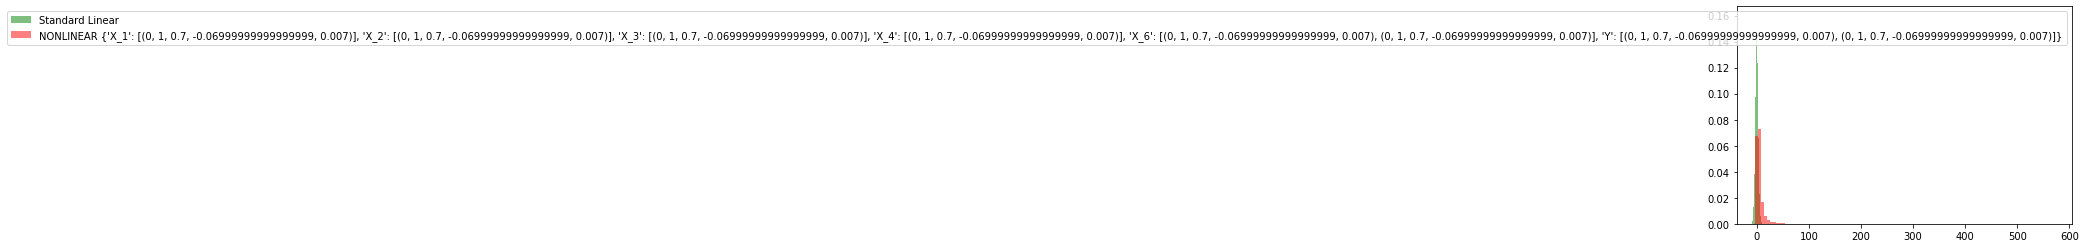

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.8 X_0**2 + -0.08 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.8 X_0**2 + -0.08 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.8 X_1**2 + -0.08 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.8 X_2**2 + -0.08 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.8 Y**2 + -0.08 Y**3 + 0.01 Y**4	 [ N := Stan

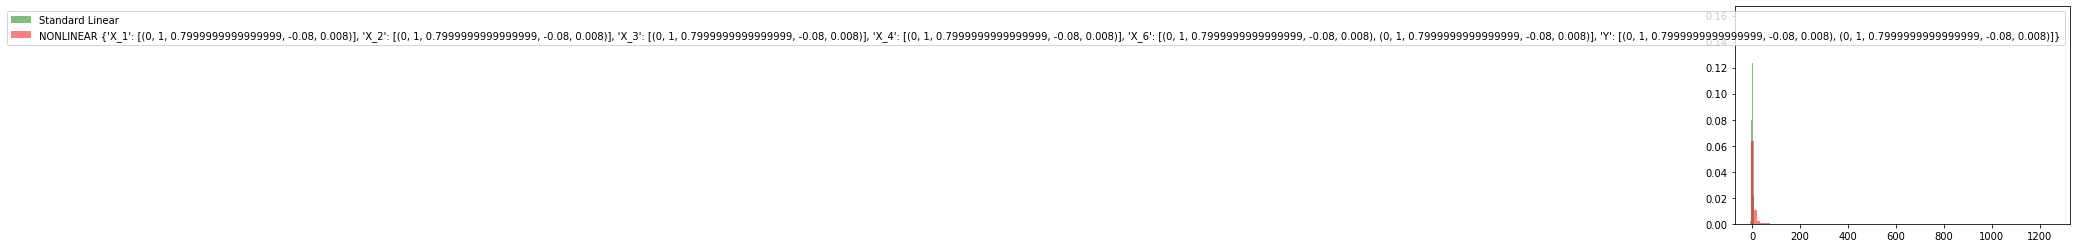

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.9 X_0**2 + -0.09 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 0.9 X_0**2 + -0.09 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 0.9 X_1**2 + -0.09 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 0.9 X_2**2 + -0.09 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 0.9 Y**2 + -0.09 Y**3 + 0.01 Y**4	 [ N := Stan

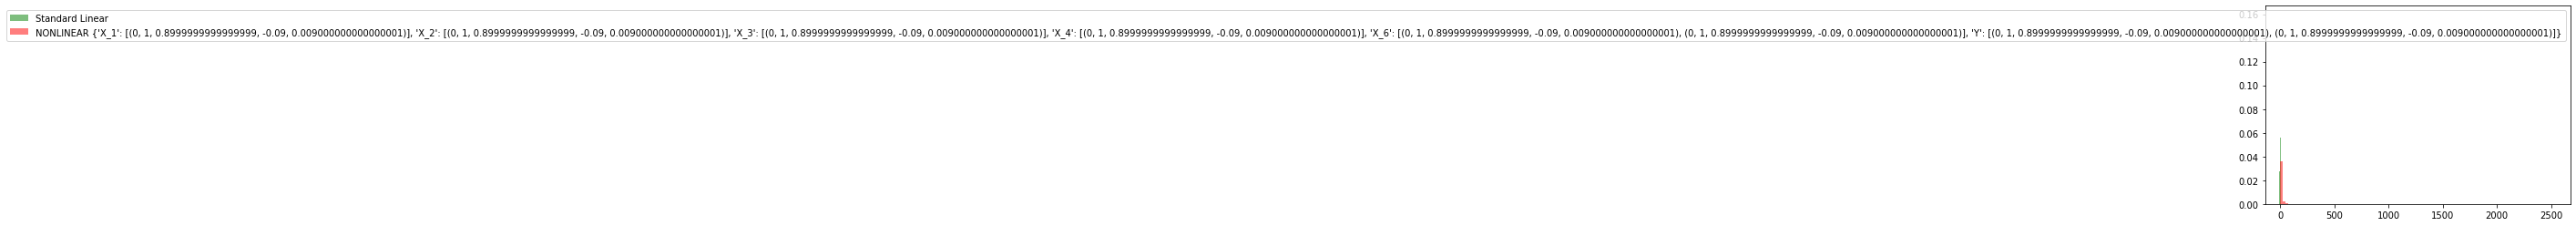

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.0 X_0**2 + -0.1 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.0 X_0**2 + -0.1 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.0 X_1**2 + -0.1 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.0 X_2**2 + -0.1 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.0 Y**2 + -0.1 Y**3 + 0.01 Y**4	 [ N := Standard 

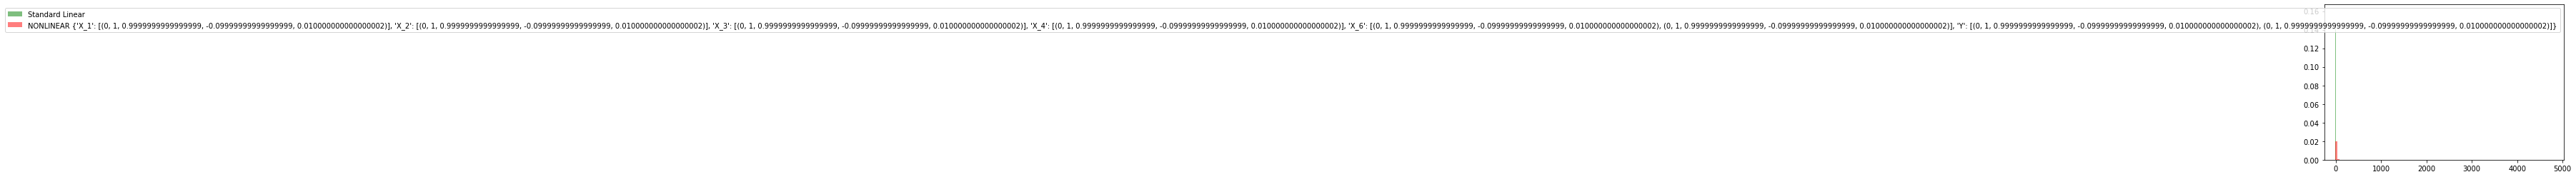

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.1 X_0**2 + -0.11 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.1 X_0**2 + -0.11 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.1 X_1**2 + -0.11 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.1 X_2**2 + -0.11 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.1 Y**2 + -0.11 Y**3 + 0.01 Y**4	 [ N := Stan

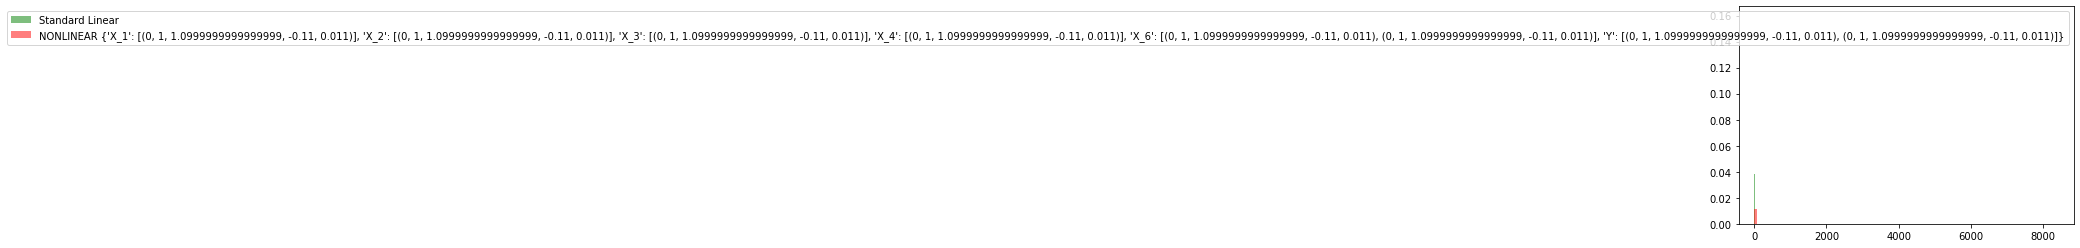

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.2 X_0**2 + -0.12 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.2 X_0**2 + -0.12 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.2 X_1**2 + -0.12 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.2 X_2**2 + -0.12 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.2 Y**2 + -0.12 Y**3 + 0.01 Y**4	 [ N := Stan

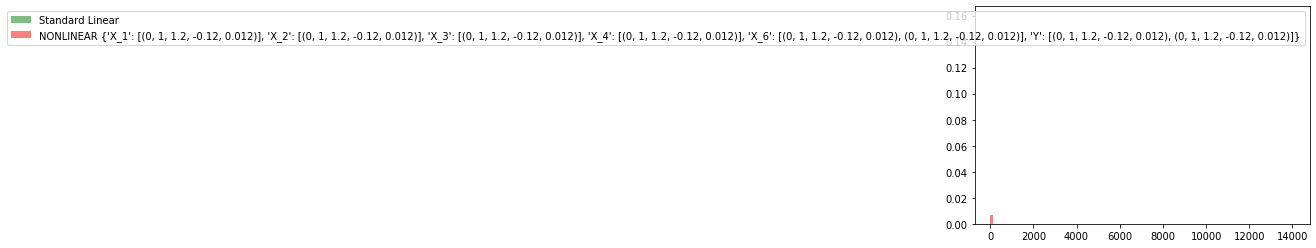

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.3 X_0**2 + -0.13 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.3 X_0**2 + -0.13 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.3 X_1**2 + -0.13 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.3 X_2**2 + -0.13 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.3 Y**2 + -0.13 Y**3 + 0.01 Y**4	 [ N := Stan

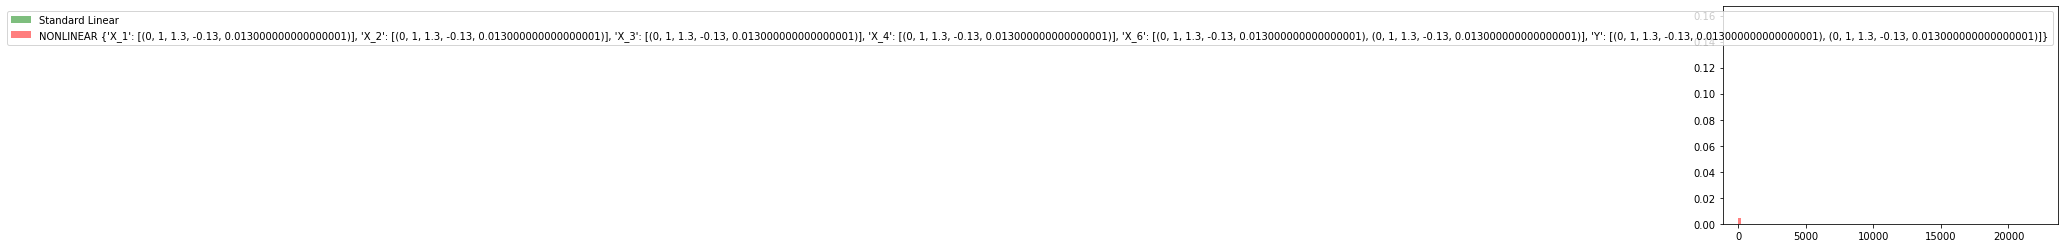

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.4 X_0**2 + -0.14 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.4 X_0**2 + -0.14 X_0**3 + 0.01 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.4 X_1**2 + -0.14 X_1**3 + 0.01 X_1**4 + 1.0 X_2 + 1.4 X_2**2 + -0.14 X_2**3 + 0.01 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.4 Y**2 + -0.14 Y**3 + 0.01 Y**4	 [ N := Stan

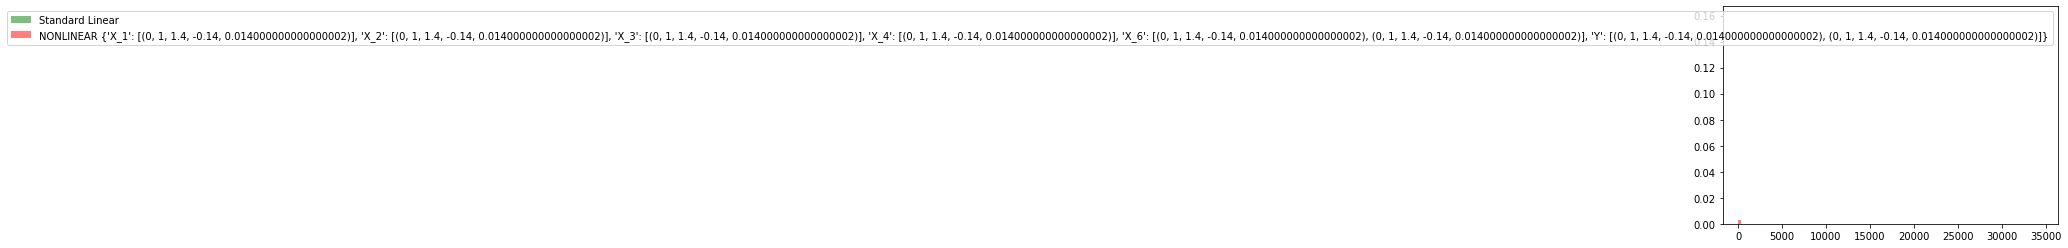

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.5 X_0**2 + -0.15 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.5 X_0**2 + -0.15 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.5 X_1**2 + -0.15 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.5 X_2**2 + -0.15 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.5 Y**2 + -0.15 Y**3 + 0.02 Y**4	 [ N := Stan

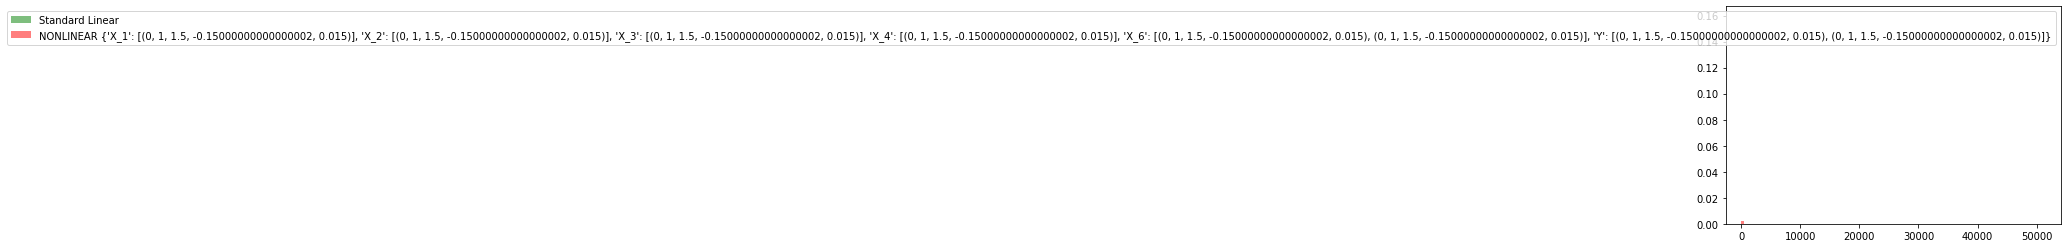

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.6 X_0**2 + -0.16 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.6 X_0**2 + -0.16 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.6 X_1**2 + -0.16 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.6 X_2**2 + -0.16 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.6 Y**2 + -0.16 Y**3 + 0.02 Y**4	 [ N := Stan

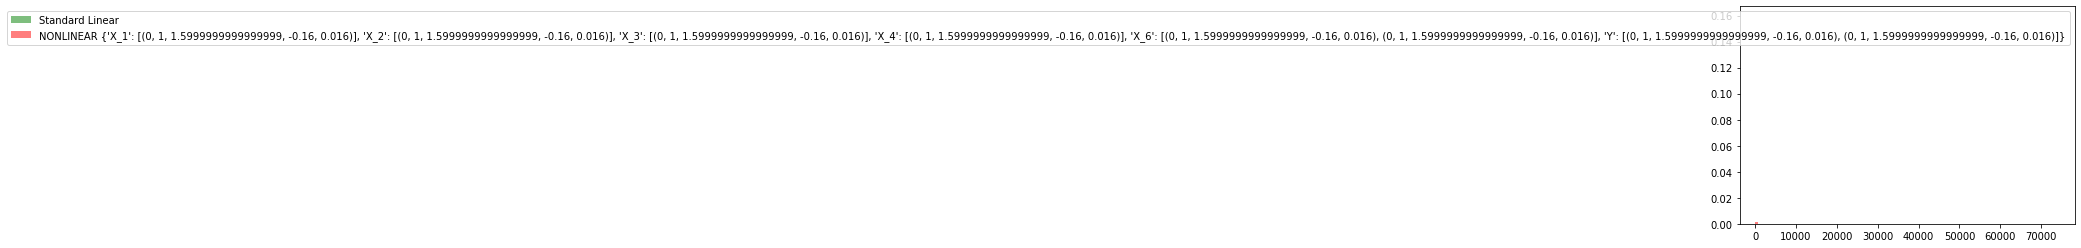

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.7 X_0**2 + -0.17 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.7 X_0**2 + -0.17 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.7 X_1**2 + -0.17 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.7 X_2**2 + -0.17 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.7 Y**2 + -0.17 Y**3 + 0.02 Y**4	 [ N := Stan

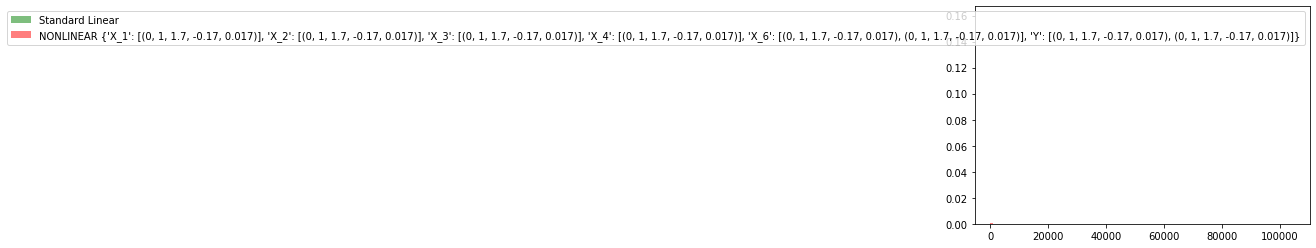

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.8 X_0**2 + -0.18 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.8 X_0**2 + -0.18 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.8 X_1**2 + -0.18 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.8 X_2**2 + -0.18 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.8 Y**2 + -0.18 Y**3 + 0.02 Y**4	 [ N := Stan

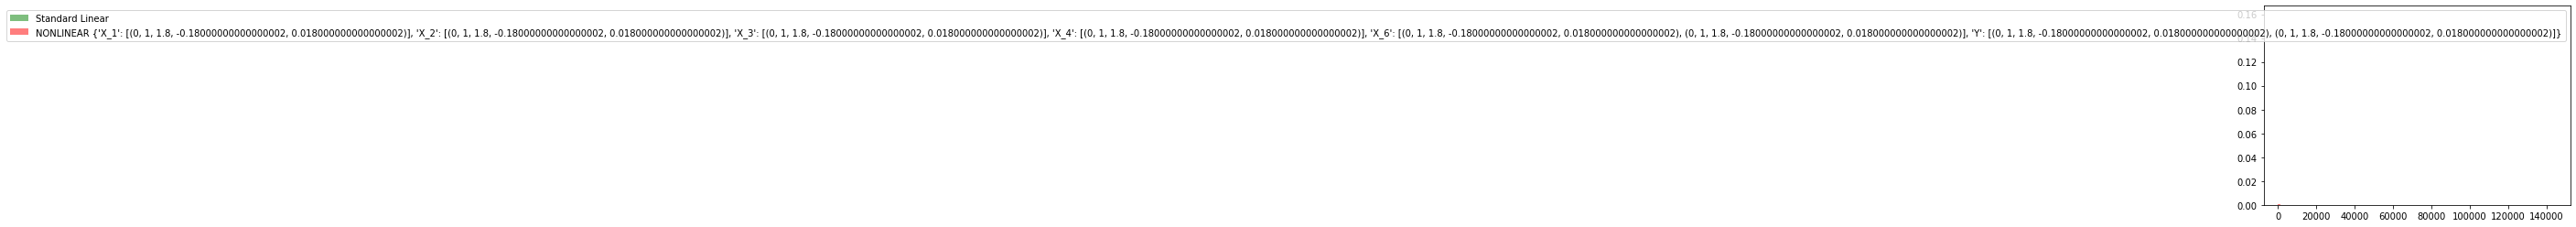

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.9 X_0**2 + -0.19 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 1.9 X_0**2 + -0.19 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 1.9 X_1**2 + -0.19 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 1.9 X_2**2 + -0.19 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 1.9 Y**2 + -0.19 Y**3 + 0.02 Y**4	 [ N := Stan

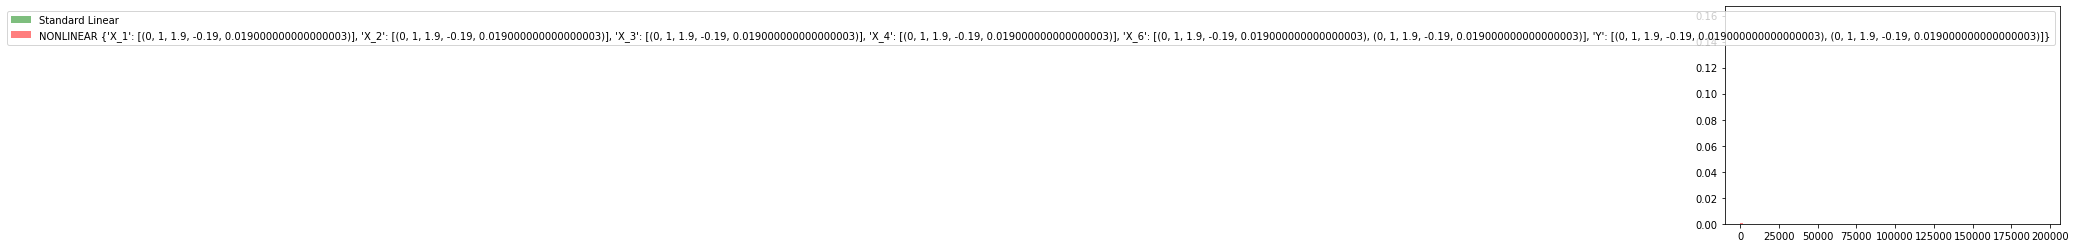

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.0 X_0**2 + -0.2 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.0 X_0**2 + -0.2 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.0 X_1**2 + -0.2 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.0 X_2**2 + -0.2 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.0 Y**2 + -0.2 Y**3 + 0.02 Y**4	 [ N := Standard 

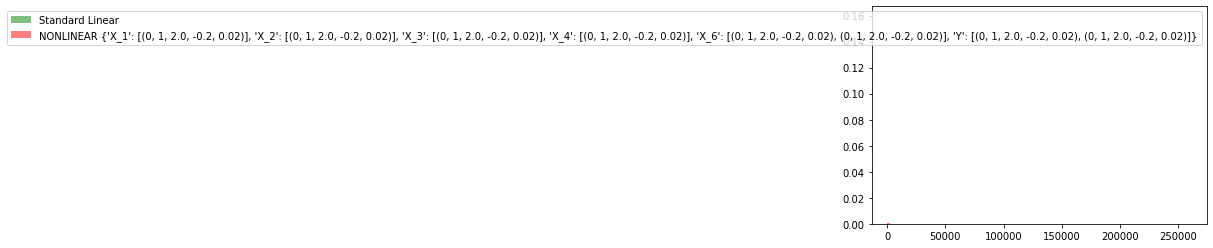

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.1 X_0**2 + -0.21 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.1 X_0**2 + -0.21 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.1 X_1**2 + -0.21 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.1 X_2**2 + -0.21 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.1 Y**2 + -0.21 Y**3 + 0.02 Y**4	 [ N := Stan

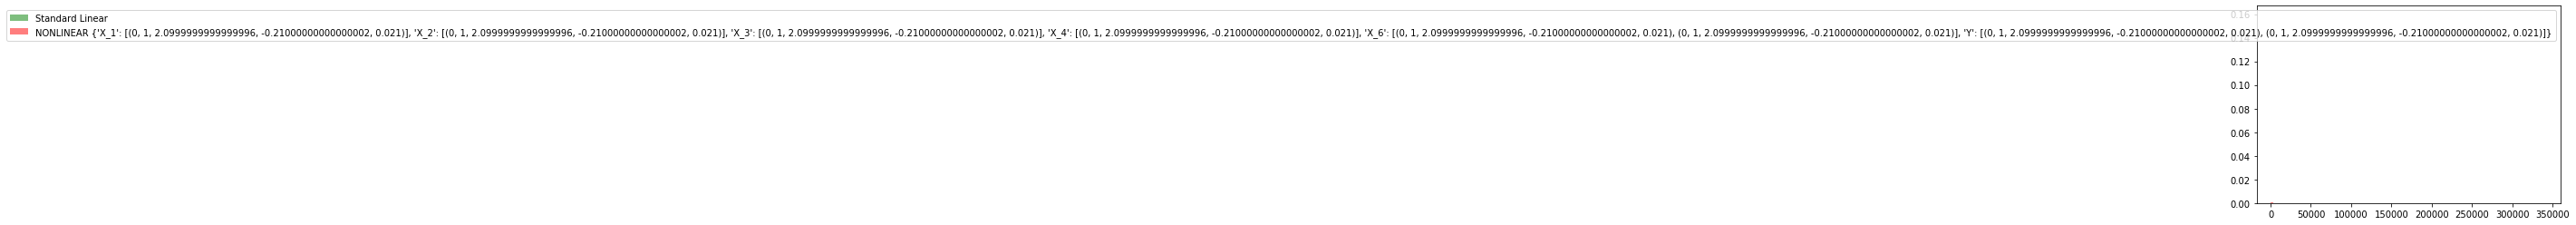

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.2 X_0**2 + -0.22 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.2 X_0**2 + -0.22 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.2 X_1**2 + -0.22 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.2 X_2**2 + -0.22 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.2 Y**2 + -0.22 Y**3 + 0.02 Y**4	 [ N := Stan

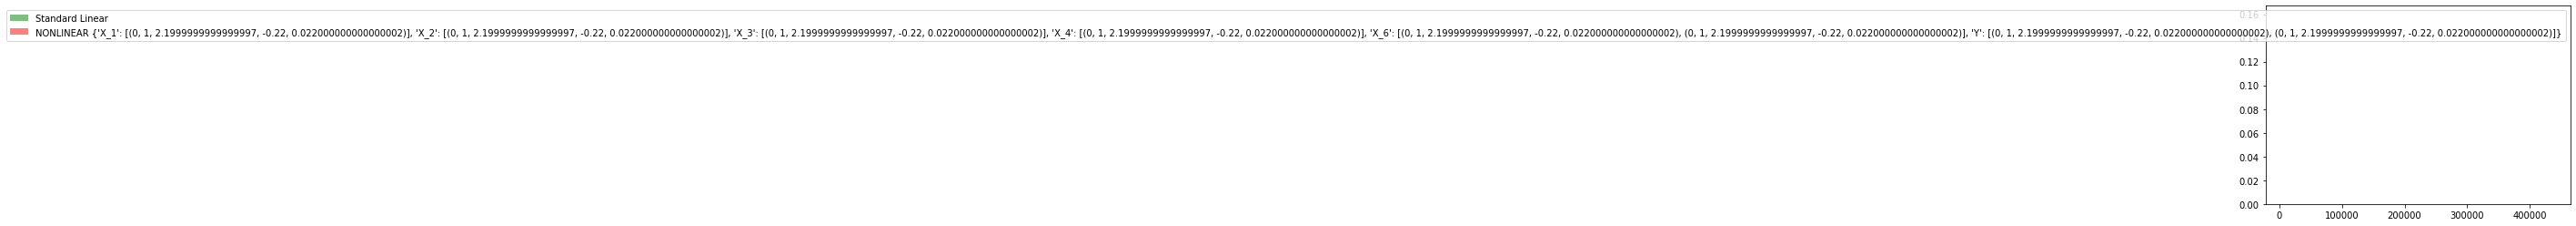

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.3 X_0**2 + -0.23 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.3 X_0**2 + -0.23 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.3 X_1**2 + -0.23 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.3 X_2**2 + -0.23 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.3 Y**2 + -0.23 Y**3 + 0.02 Y**4	 [ N := Stan

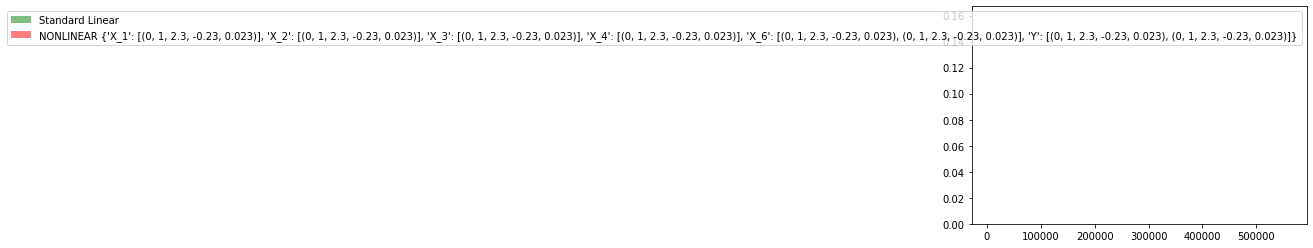

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.4 X_0**2 + -0.24 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.4 X_0**2 + -0.24 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.4 X_1**2 + -0.24 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.4 X_2**2 + -0.24 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.4 Y**2 + -0.24 Y**3 + 0.02 Y**4	 [ N := Stan

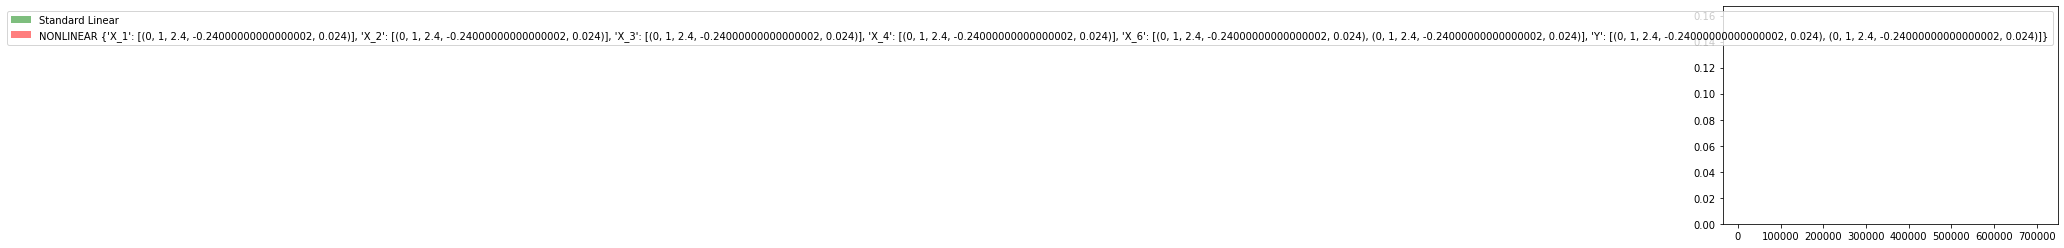

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.5 X_0**2 + -0.25 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.5 X_0**2 + -0.25 X_0**3 + 0.02 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.5 X_1**2 + -0.25 X_1**3 + 0.02 X_1**4 + 1.0 X_2 + 2.5 X_2**2 + -0.25 X_2**3 + 0.02 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.5 Y**2 + -0.25 Y**3 + 0.02 Y**4	 [ N := Stan

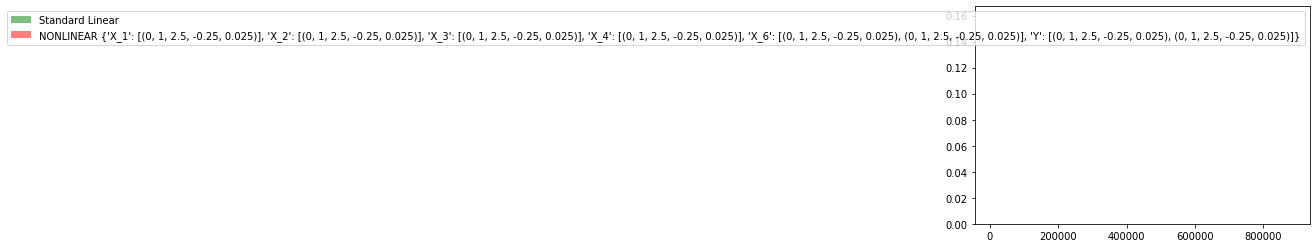

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.6 X_0**2 + -0.26 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.6 X_0**2 + -0.26 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.6 X_1**2 + -0.26 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.6 X_2**2 + -0.26 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.6 Y**2 + -0.26 Y**3 + 0.03 Y**4	 [ N := Stan

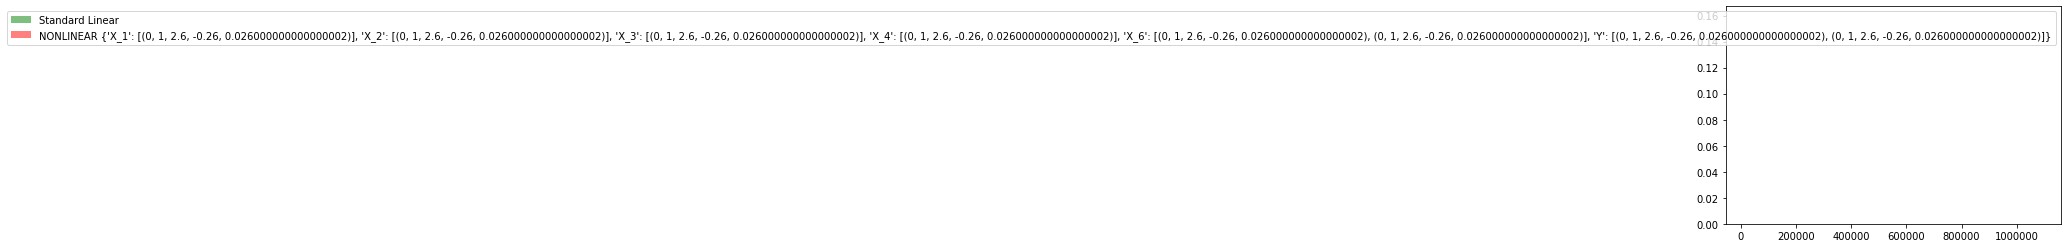

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.7 X_0**2 + -0.27 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.7 X_0**2 + -0.27 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.7 X_1**2 + -0.27 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.7 X_2**2 + -0.27 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.7 Y**2 + -0.27 Y**3 + 0.03 Y**4	 [ N := Stan

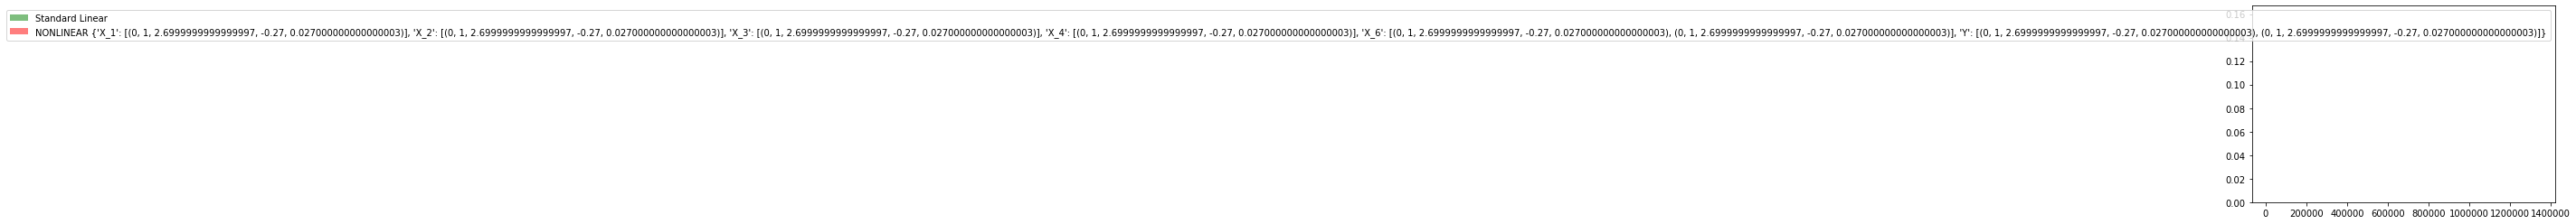

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.8 X_0**2 + -0.28 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.8 X_0**2 + -0.28 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.8 X_1**2 + -0.28 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.8 X_2**2 + -0.28 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.8 Y**2 + -0.28 Y**3 + 0.03 Y**4	 [ N := Stan

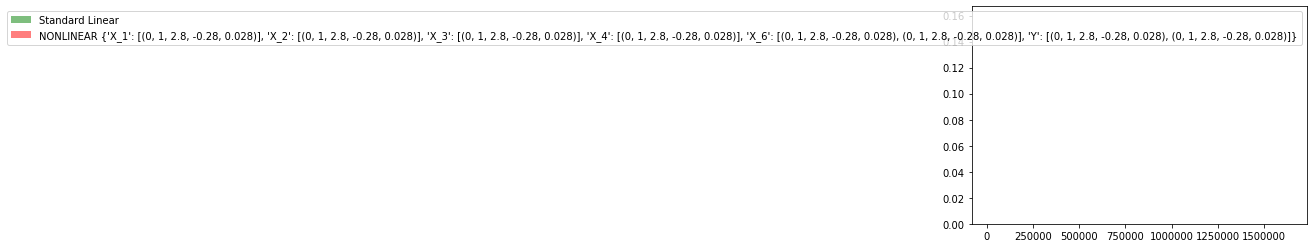

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.9 X_0**2 + -0.29 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 2.9 X_0**2 + -0.29 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 2.9 X_1**2 + -0.29 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 2.9 X_2**2 + -0.29 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 2.9 Y**2 + -0.29 Y**3 + 0.03 Y**4	 [ N := Stan

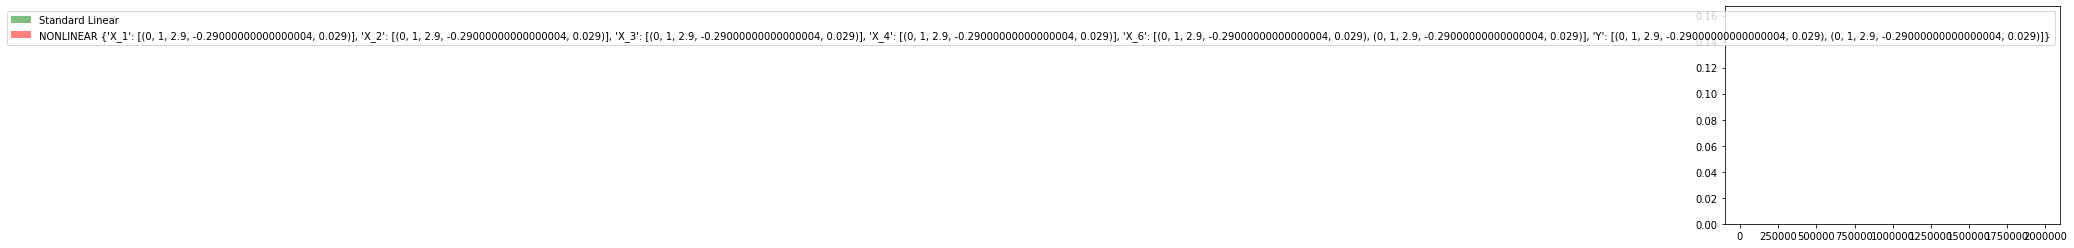

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.0 X_0**2 + -0.3 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.0 X_0**2 + -0.3 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.0 X_1**2 + -0.3 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.0 X_2**2 + -0.3 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.0 Y**2 + -0.3 Y**3 + 0.03 Y**4	 [ N := Standard 

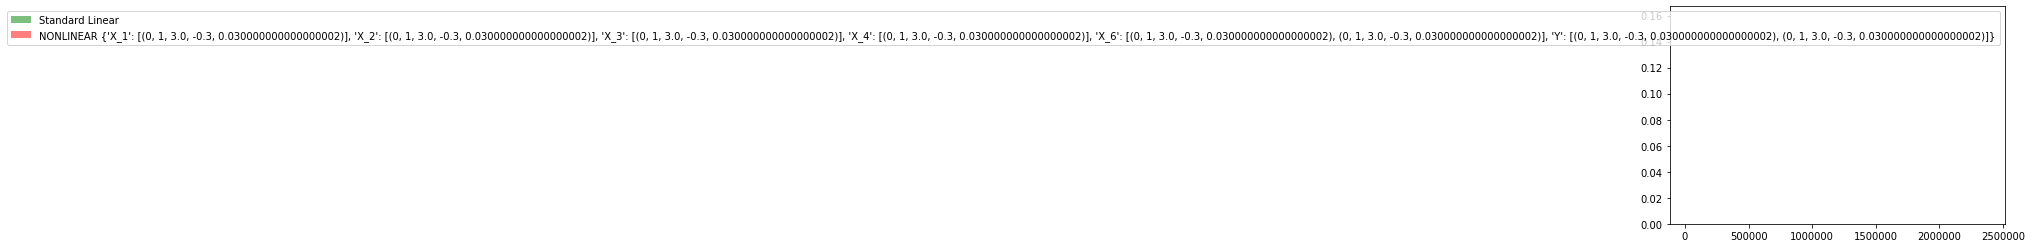

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.1 X_0**2 + -0.31 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.1 X_0**2 + -0.31 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.1 X_1**2 + -0.31 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.1 X_2**2 + -0.31 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.1 Y**2 + -0.31 Y**3 + 0.03 Y**4	 [ N := Stan

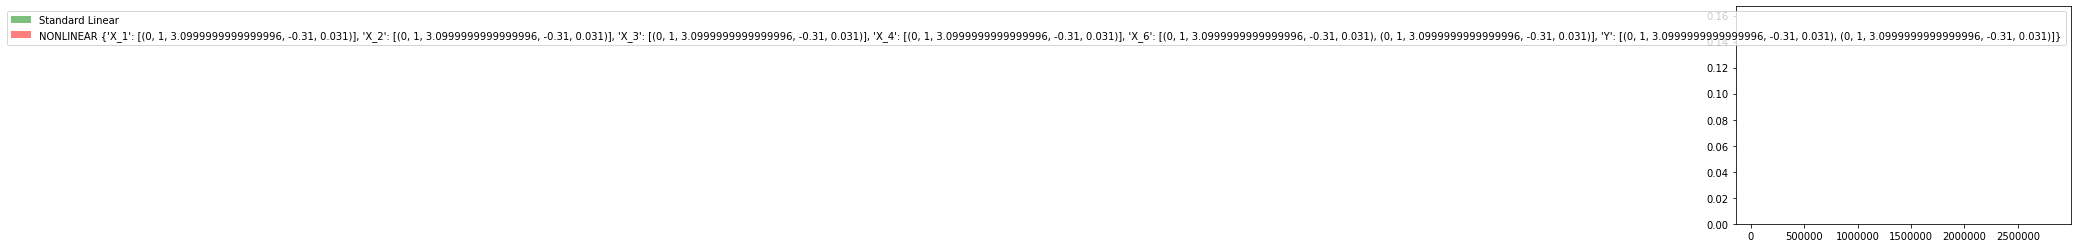

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.2 X_0**2 + -0.32 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.2 X_0**2 + -0.32 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.2 X_1**2 + -0.32 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.2 X_2**2 + -0.32 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.2 Y**2 + -0.32 Y**3 + 0.03 Y**4	 [ N := Stan

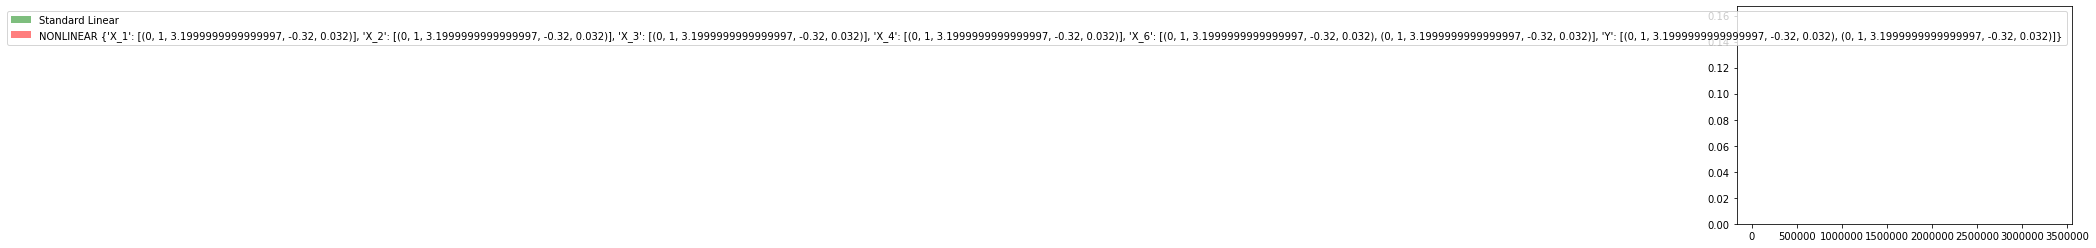

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.3 X_0**2 + -0.33 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.3 X_0**2 + -0.33 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.3 X_1**2 + -0.33 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.3 X_2**2 + -0.33 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.3 Y**2 + -0.33 Y**3 + 0.03 Y**4	 [ N := Stan

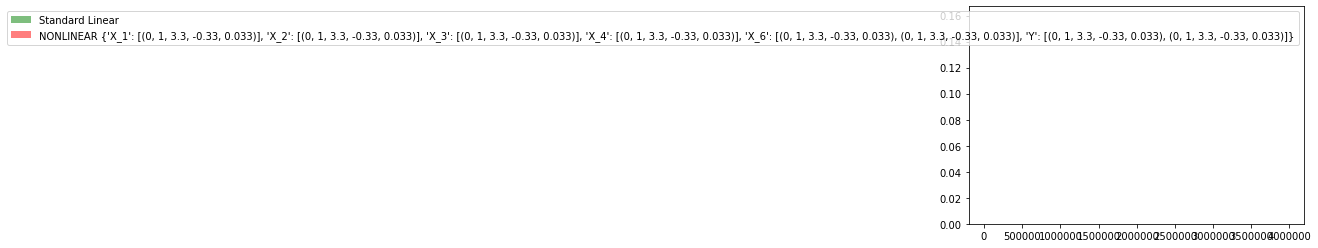

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.4 X_0**2 + -0.34 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.4 X_0**2 + -0.34 X_0**3 + 0.03 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.4 X_1**2 + -0.34 X_1**3 + 0.03 X_1**4 + 1.0 X_2 + 3.4 X_2**2 + -0.34 X_2**3 + 0.03 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.4 Y**2 + -0.34 Y**3 + 0.03 Y**4	 [ N := Stan

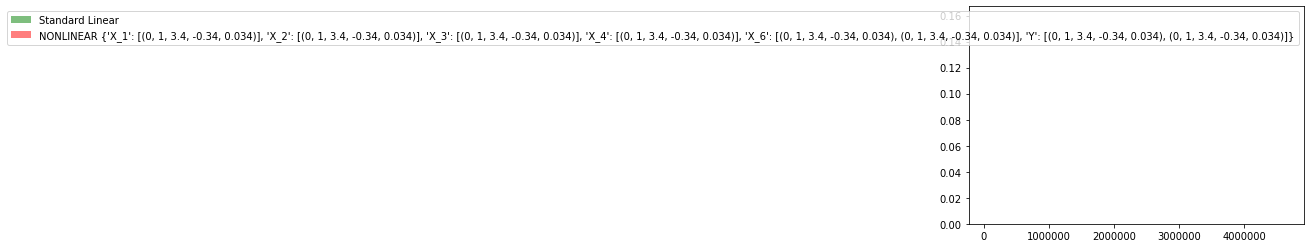

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.5 X_0**2 + -0.35 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.5 X_0**2 + -0.35 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.5 X_1**2 + -0.35 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.5 X_2**2 + -0.35 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.5 Y**2 + -0.35 Y**3 + 0.04 Y**4	 [ N := Stan

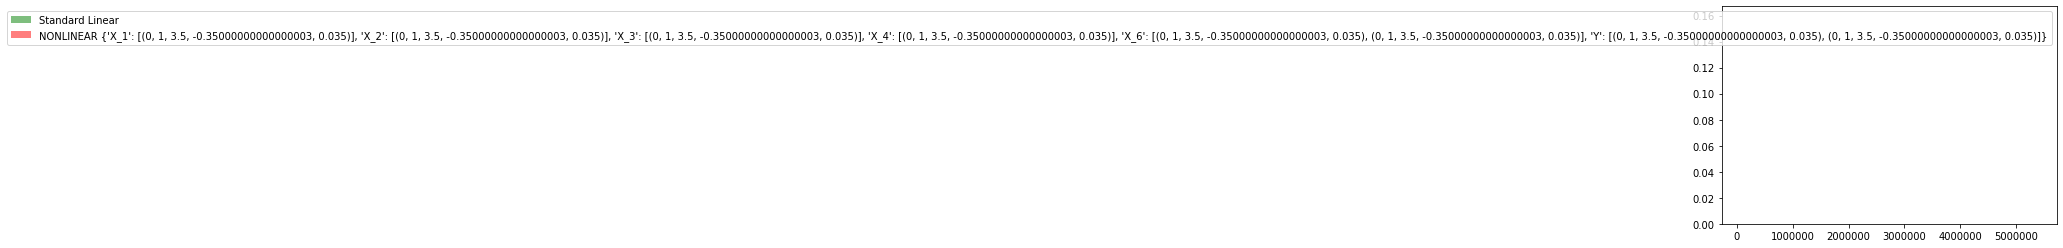

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.6 X_0**2 + -0.36 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.6 X_0**2 + -0.36 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.6 X_1**2 + -0.36 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.6 X_2**2 + -0.36 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.6 Y**2 + -0.36 Y**3 + 0.04 Y**4	 [ N := Stan

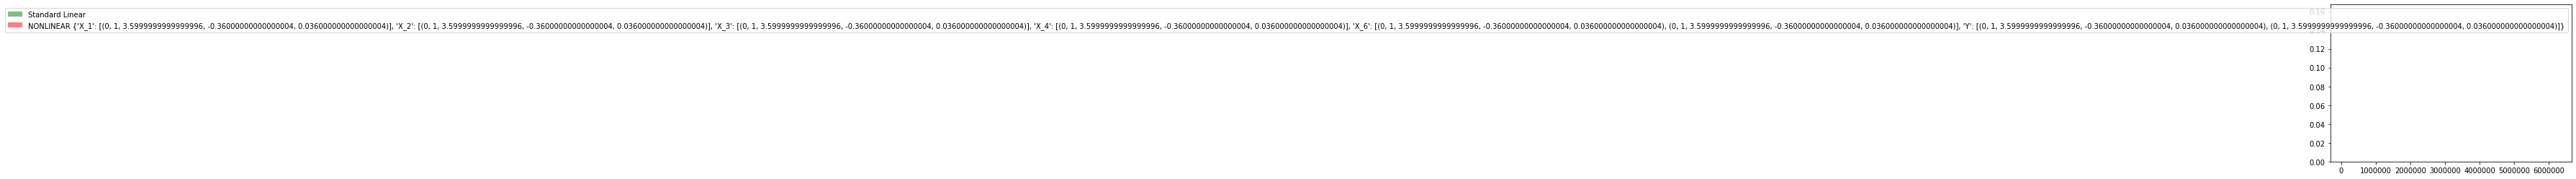

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.7 X_0**2 + -0.37 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.7 X_0**2 + -0.37 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.7 X_1**2 + -0.37 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.7 X_2**2 + -0.37 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.7 Y**2 + -0.37 Y**3 + 0.04 Y**4	 [ N := Stan

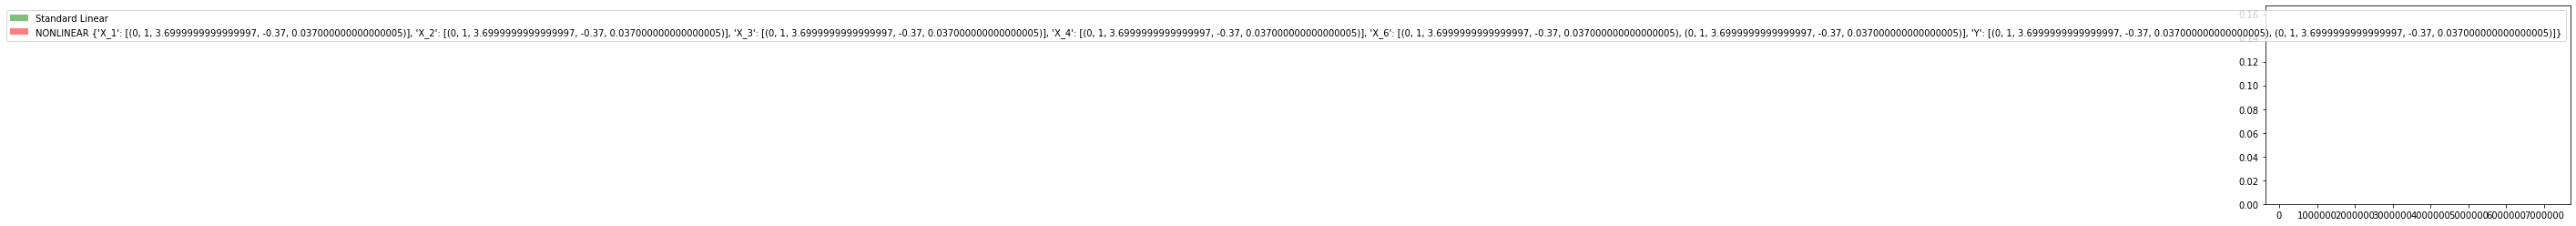

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.8 X_0**2 + -0.38 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.8 X_0**2 + -0.38 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.8 X_1**2 + -0.38 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.8 X_2**2 + -0.38 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.8 Y**2 + -0.38 Y**3 + 0.04 Y**4	 [ N := Stan

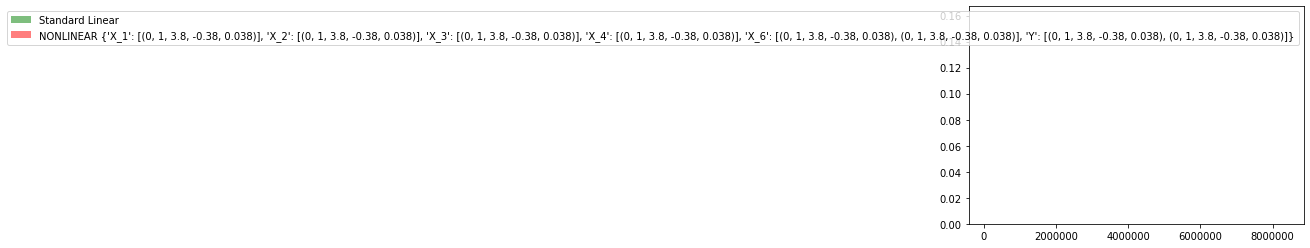

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.9 X_0**2 + -0.39 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 3.9 X_0**2 + -0.39 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 3.9 X_1**2 + -0.39 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 3.9 X_2**2 + -0.39 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 3.9 Y**2 + -0.39 Y**3 + 0.04 Y**4	 [ N := Stan

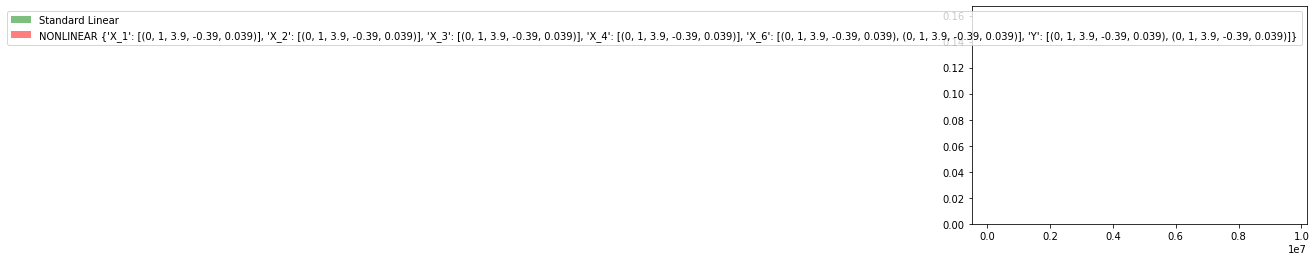

Environment 1: Intervention on variable X_2 for value [0.80936014].
Environment 2: Intervention on variable X_6 for value [0.12292057].
Environment 3: Intervention on variable X_3 for value [-2.43981072].
Environment 4: Intervention on variable X_1 for value [-2.73826673].
Environment 5: Intervention on variable X_5 for value [2.18848968].
Structural Causal Model of 9 variables: X_0, X_1, X_2, Y, X_3, X_4, X_5, X_6, X_7
Following variables are actively intervened on: []
Current Assignment Functions are:
X_0 := f(N) = 1.0 N	 [ N := Standard Normal ]
X_1 := f(N, X_0) = 1.0 N + 1.0 X_0 + 4.0 X_0**2 + -0.4 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
X_2 := f(N, X_0) = 1.0 N + 1.0 X_0 + 4.0 X_0**2 + -0.4 X_0**3 + 0.04 X_0**4	 [ N := Standard Normal ]
  Y := f(N, X_1, X_2) = 1.0 N + 1.0 X_1 + 4.0 X_1**2 + -0.4 X_1**3 + 0.04 X_1**4 + 1.0 X_2 + 4.0 X_2**2 + -0.4 X_2**3 + 0.04 X_2**4	 [ N := Standard Normal ]
X_3 := f(N, Y) = 1.0 N + 1.0 Y + 4.0 Y**2 + -0.4 Y**3 + 0.04 Y**4	 [ N := Standard 

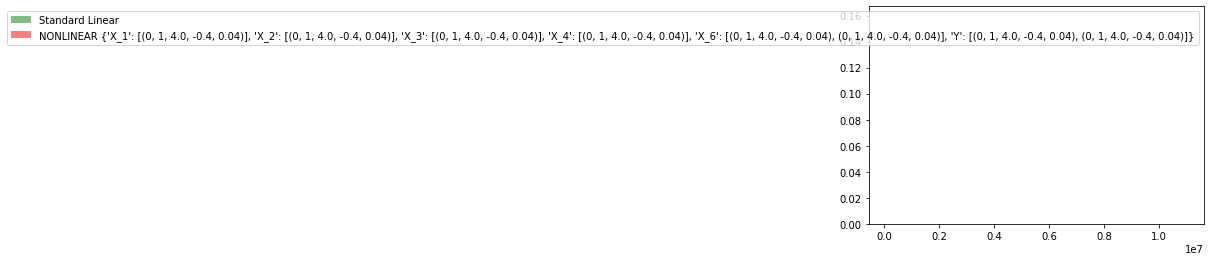

In [9]:

steps = 40
sample_size = 4096
nr_runs = 20
epochs = 1000
results = []
scenarios = ["parents", "children", "target", "all"]
# we test 4 scenarios:
# 1. increasing nonlinearity in the parents,
# 2. increasing nonlinearity in the children,
# 3. increasing nonlinearity on the target,
# 4. increasing nonlinearity on all
for scenario in scenarios:
    for step, coeffs in enumerate(
        zip(
            [0] * steps,
            [1] * steps,
            np.linspace(0.1, 4, steps),
            np.linspace(-0.01, -0.4, steps),
            np.linspace(0.001, 0.04, steps),
        )
    ):
        run_scenario(
            return_coeffs_by_var(coeffs, scenario),
            nr_epochs=epochs,
            nr_runs=nr_runs,
            scenario=scenario,
            epochs=epochs,
            step=step,
            sample_size=sample_size
        )

